# Valorisation entreprise test ...
A l'aide de ce notebook nous voulons construire une base de données contenant le maximum possible d'entreprise dont les ratios EV sont nulles 

## Packages 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import copy
import pickle as pk
from sklearn.preprocessing import LabelEncoder, RobustScaler, MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score 
from sklearn import datasets
from tensorflow import keras
from keras import layers, optimizers, regularizers
import statsmodels.api as sm
import pickle

## Construction de la dataset

In [3]:
data = pd.read_excel ( 'Data Finpack V2/Data_Finpack_V2.xlsx' )
data

Efcode  isActive Ticker Country                   Company Name  \
0      30019LI      True    NaN     NIC              BANCO DE FINANZAS   
1      30019LI      True    NaN     NIC              BANCO DE FINANZAS   
2      30024LI      True    NaN     NIC         BANCO DE LA PRODUCCION   
3      30024LI      True    NaN     NIC         BANCO DE LA PRODUCCION   
4      30015LI      True    NaN     NIC  BOLSA DE VALORES DE NICARAGUA   
...        ...       ...    ...     ...                            ...   
83786  30217AN      True    XRO     NZL                   Xero Limited   
83787  40023AN      True    IKE     NZL               ikeGPS Group Ltd   
83788  30207AN      True    NaN     NZL                      smartFONZ   
83789  30208AN      True    NaN     NZL                      smartMIDZ   
83790  30204AN      True    NaN     NZL                      smartTENZ   

               ISIN                         Sector  \
0               NaN                          Banks   
1               NaN                          Banks   
2               NaN  Equity Investment Instruments   
3               NaN  Equity Investment Instruments   
4               NaN            Investment Services   
...             ...                            ...   
83786  NZXROE0001S2                       Software   
83787  NZIKEE0001S9           Electronic Equipment   
83788  NZFNZE0001S4  Equity Investment Instruments   
83789  NZMDZE0001S1                          Banks   
83790  NZTNZE0001S5  Equity Investment Instruments   

                                             Description EV/EBITDA - Last  \
0      WVB Short Business Summary Consumer banking wi...              NaN   
1      WVB Short Business Summary Consumer banking wi...              NaN   
2      WVB Short Business Summary The Bank is a priva...              NaN   
3      WVB Short Business Summary The Bank is a priva...              NaN   
4      WVB Short Business Summary The main activities...              NaN   
...                                                  ...              ...   
83786  S&P Business SummaryXero Limited, together wit...            57.97   
83787  S&P Business SummaryikeGPS Group Limited, toge...              N/M   
83788  S&P Business SummarySmartshares NZ Top 50 ETF ...              NaN   
83789  S&P Business SummarySmartshares NZ Mid Cap ETF...              NaN   
83790  S&P Business SummaryNZX 10 Fund is an exchange...              NaN   

      P/E (e) - 2023  ... ROCE (%) - Last Net Debt / Equity (x) - 2022  \
0                NaN  ...             NaN                          NaN   
1                NaN  ...             NaN                          NaN   
2                NaN  ...             NaN                          NaN   
3                NaN  ...             NaN                          NaN   
4                NaN  ...           -1.25                          NaN   
...              ...  ...             ...                          ...   
83786     109.366108  ...           -4.89                          NaN   
83787            NaN  ...          -35.73                        -0.54   
83788            NaN  ...            N/M-                          NaN   
83789            NaN  ...            2.62                          NaN   
83790            NaN  ...            N/M-                          NaN   

      Net Debt / EBITDA (x) - 2022  ROE (%) - 2022  ROA - 2022  \
0                              NaN             NaN         NaN   
1                              NaN             NaN         NaN   
2                              NaN           11.51         1.7   
3                              NaN           11.51         1.7   
4                              NaN           -1.02       -0.86   
...                            ...             ...         ...   
83786                          NaN          -10.88        -4.7   
83787                         3.96          -21.57      -17.24   
83788                          NaN             NaN         NaN

### EV/EBITDA, P/E

In [4]:
data ['P/Book Value - Last']

0          NaN
1          NaN
2          NaN
3          NaN
4          NaN
         ...  
83786    12.84
83787     3.38
83788      NaN
83789      NaN
83790      NaN
Name: P/Book Value - Last, Length: 83791, dtype: object

#### Suppression des valeurs nulles et valeurs N/M

In [5]:
#Suppression des lignes dont P/E est nulles 
indexes_a_supprimer = data[ data['P/Book Value - Last'].isna() ].index
data_V1 = data.drop ( indexes_a_supprimer, axis = 0 )

#Suppression des valeurs N/M de EV/EBITDA 
indexes_a_supprimer = data_V1 [data_V1 ['P/Book Value - Last'] == 'N/M'].index
data_V2 = data_V1.drop ( indexes_a_supprimer, axis = 0 )
data_V2

Efcode  isActive    Ticker Country                      Company Name  \
23     30145KN      True  ABCTRANS     NGA                 ABC Transport PLC   
28     30238KN      True  ABBEYBDS     NGA           Abbey Mortgage Bank Plc   
30     30268KN      True  AFRIPRUD     NGA             Africa Prudential Plc   
34     30163KN      True     AIICO     NGA               Aiico Insurance PLC   
36     30033KN      True    ARDOVA     NGA                        Ardova Plc   
...        ...       ...       ...     ...                               ...   
83778  30160AN      True       VTL     NZL                     Vital Limited   
83779  40089AN      True       VHT     NZL  Volpara Health Technologies Ltd.   
83783  30035AN      True       WHS     NZL              Warehouse Group Ltd.   
83786  30217AN      True       XRO     NZL                      Xero Limited   
83787  40023AN      True       IKE     NZL                  ikeGPS Group Ltd   

               ISIN                     Sector  \
23     NGABCTRANS01           Travel & Tourism   
28     NGABBEY00001                      Banks   
30     NGAFRIPRUD04        Investment Services   
34     NGAIICO00006        Full Line Insurance   
36     NGAP00000004       Integrated Oil & Gas   
...             ...                        ...   
83778  NZTTKE0001S4  Mobile Telecommunications   
83779  NZVHTE0001S6              Biotechnology   
83783  NZWHSE0001S6        Broadline Retailers   
83786  NZXROE0001S2                   Software   
83787  NZIKEE0001S9       Electronic Equipment   

                                             Description EV/EBITDA - Last  \
23     S&P Business SummaryABC Transport Plc provides...             2.62   
28     S&P Business SummaryAbbey Mortgage Bank Plc pr...              NaN   
30     S&P Business SummaryAfrica Prudential Plc prov...            34.04   
34     S&P Business SummaryAIICO Insurance Plc provid...              NaN   
36     S&P Business SummaryArdova Plc, an integrated ...            54.07   
...                                                  ...              ...   
83778  S&P Business SummaryVital Limited provides mob...              2.3   
83779  S&P Business SummaryVolpara Health Technologie...              N/M   
83783  S&P Business SummaryThe Warehouse Group Limite...             2.24   
83786  S&P Business SummaryXero Limited, together wit...            57.97   
83787  S&P Business SummaryikeGPS Group Limited, toge...              N/M   

      P/E (e) - 2023  ... ROCE (%) - Last Net Debt / Equity (x) - 2022  \
23               NaN  ...           12.11                          NaN   
28               NaN  ...             NaN                          NaN   
30               NaN  ...           -3.09                          NaN   
34               NaN  ...             NaN                          NaN   
36               NaN  ...           -3.57                         5.75   
...              ...  ...             ...                          ...   
83778            NaN  ...          -25.55                          NaN   
83779            N/M  ...          -22.26                          NaN   
83783      14.930191  ...            10.9                         0.10   
83786     109.366108  ...           -4.89                          NaN   
83787            NaN  ...          -35.73                        -0.54   

      Net Debt / EBITDA (x) - 2022  ROE (%) - 2022  ROA - 2022  \
23                             NaN             NaN         NaN   
28                             NaN             NaN         NaN   
30                             NaN           16.45        8.52   
34                             NaN           18.01        3.02   
36                           36.57           -59.9       -5.96   
...                            ...             ...         ...   
83778                          NaN             NaN         NaN   
83779                          NaN          -17.96      -12.24   
83783                         0.13    

In [6]:
#le nouveau Nombre de valeurs nulles dans EV/EBITDA
data_V1['P/Book Value - Last'].isna().sum()

0

In [7]:
#pourcentage de valeurs nulles par colonne
pourcentage_na_colonne = data_V2.isna().sum()*100/data_V2.shape[0]
fig1 = px.bar  ( pourcentage_na_colonne, width = 1400 )
fig1.show()

In [8]:
#Nous allons supprimées tout les colonnes dont le pourcentage de valeur nulles > = 14,1%
pourcentage = 17.09
colonnes_a_supprimer = pourcentage_na_colonne [pourcentage_na_colonne >= pourcentage ].index
data_V3 = data_V2.drop ( colonnes_a_supprimer, axis = 1 )
data_V3

Efcode  isActive    Ticker Country                      Company Name  \
23     30145KN      True  ABCTRANS     NGA                 ABC Transport PLC   
28     30238KN      True  ABBEYBDS     NGA           Abbey Mortgage Bank Plc   
30     30268KN      True  AFRIPRUD     NGA             Africa Prudential Plc   
34     30163KN      True     AIICO     NGA               Aiico Insurance PLC   
36     30033KN      True    ARDOVA     NGA                        Ardova Plc   
...        ...       ...       ...     ...                               ...   
83778  30160AN      True       VTL     NZL                     Vital Limited   
83779  40089AN      True       VHT     NZL  Volpara Health Technologies Ltd.   
83783  30035AN      True       WHS     NZL              Warehouse Group Ltd.   
83786  30217AN      True       XRO     NZL                      Xero Limited   
83787  40023AN      True       IKE     NZL                  ikeGPS Group Ltd   

               ISIN                     Sector  \
23     NGABCTRANS01           Travel & Tourism   
28     NGABBEY00001                      Banks   
30     NGAFRIPRUD04        Investment Services   
34     NGAIICO00006        Full Line Insurance   
36     NGAP00000004       Integrated Oil & Gas   
...             ...                        ...   
83778  NZTTKE0001S4  Mobile Telecommunications   
83779  NZVHTE0001S6              Biotechnology   
83783  NZWHSE0001S6        Broadline Retailers   
83786  NZXROE0001S2                   Software   
83787  NZIKEE0001S9       Electronic Equipment   

                                             Description EV/EBITDA - Last  \
23     S&P Business SummaryABC Transport Plc provides...             2.62   
28     S&P Business SummaryAbbey Mortgage Bank Plc pr...              NaN   
30     S&P Business SummaryAfrica Prudential Plc prov...            34.04   
34     S&P Business SummaryAIICO Insurance Plc provid...              NaN   
36     S&P Business SummaryArdova Plc, an integrated ...            54.07   
...                                                  ...              ...   
83778  S&P Business SummaryVital Limited provides mob...              2.3   
83779  S&P Business SummaryVolpara Health Technologie...              N/M   
83783  S&P Business SummaryThe Warehouse Group Limite...             2.24   
83786  S&P Business SummaryXero Limited, together wit...            57.97   
83787  S&P Business SummaryikeGPS Group Limited, toge...              N/M   

      EV/EBIT - Last  ...  Sales To Assets (%) - Last.1  \
23              5.35  ...                        108.03   
28               NaN  ...                           NaN   
30             51.96  ...                          8.74   
34               NaN  ...                         32.48   
36               N/M  ...                        179.15   
...              ...  ...                           ...   
83778            N/M  ...                           NaN   
83779            N/M  ...                           NaN   
83783            4.3  ...                           NaN   
83786         327.79  ...                           NaN   
83787            N/M  ...                           NaN   

       Fin. Debt / Assets (%) - Last.1 Net Sales - Last.1 EBITDA - Last  \
23                               21.38          15.569810      1.763778   
28                                0.67                NaN           NaN   
30                                   0           3.263938     -0.030324   
34                                8.43         191.402278           NaN   
36                               41.02         524.974293      3.180169   
...                                ...                ...           ...   
83778                              NaN                NaN      6.969482   
83779                              NaN                NaN     -4.936773   
83783                              NaN                NaN    191.716090   
83786                              NaN                NaN    1

In [10]:
#Les colonnes restant
data_V3.columns

Index(['Efcode', 'isActive', 'Ticker', 'Country', 'Company Name', 'ISIN',
       'Sector', 'Description', 'EV/EBITDA - Last', 'EV/EBIT - Last',
       'Net Debt / Equity (x) - Last', 'Net Sales - Last', 'P/E - Last',
       'EV/Sales - Last', 'P/E - 2021', 'P/Book Value - Last',
       'Entreprise Value - Last', 'ROA - Last', 'Sales To Assets (%) - Last',
       'Sales To Receiv. - Last', 'Fin. Debt / Equity (%) - Last',
       'Fin. Debt / Assets (%) - Last', 'Net Debt / EBITDA (x) - Last',
       'Sales To Assets (%) - Last.1', 'Fin. Debt / Assets (%) - Last.1',
       'Net Sales - Last.1', 'EBITDA - Last', 'Total Assets - Last',
       'Sharehold. Equity - Last', 'EBITDA Marg. (%) - Last',
       'EBIT Marg. (%) - Last', 'ROE (%) - Last', 'ROCE (%) - Last'],
      dtype='object')

In [11]:
px.bar ( data_V3.isna().sum()*100/data_V3.shape[0] )

In [12]:
#Si on supprime tout les valeurs nulles, ca serai quoi la taille de la data 
data_test = data_V3.dropna()
data_test.shape

(18378, 33)

In [13]:
#Supprimons des colonnes de la data ,'Fin. Debt / Equity (%) - Last', 'Fin. Debt / Assets (%) - Last', 'Net Debt / EBITDA (x) - Last'  , 
a_supprimer = ['isActive', 'Ticker', 'ISIN'  ,  'EV/EBIT - Last', 'P/E - Last', 'EV/Sales - Last', 'P/E - 2021','P/Book Value - Last', 'Entreprise Value - Last' ]
data_V4 = data_V3.drop ( a_supprimer , axis = 1 )
#data_V4 = data_V3 [['Efcode','Country', 'Company Name', 'Sector', 'Description', 'EBITDA - Last',  'EBITDA Marg. (%) - Last', 'P/Book Value - Last']]
data_V4

Efcode Country                      Company Name  \
23     30145KN     NGA                 ABC Transport PLC   
28     30238KN     NGA           Abbey Mortgage Bank Plc   
30     30268KN     NGA             Africa Prudential Plc   
34     30163KN     NGA               Aiico Insurance PLC   
36     30033KN     NGA                        Ardova Plc   
...        ...     ...                               ...   
83778  30160AN     NZL                     Vital Limited   
83779  40089AN     NZL  Volpara Health Technologies Ltd.   
83783  30035AN     NZL              Warehouse Group Ltd.   
83786  30217AN     NZL                      Xero Limited   
83787  40023AN     NZL                  ikeGPS Group Ltd   

                          Sector  \
23              Travel & Tourism   
28                         Banks   
30           Investment Services   
34           Full Line Insurance   
36          Integrated Oil & Gas   
...                          ...   
83778  Mobile Telecommunications   
83779              Biotechnology   
83783        Broadline Retailers   
83786                   Software   
83787       Electronic Equipment   

                                             Description EV/EBITDA - Last  \
23     S&P Business SummaryABC Transport Plc provides...             2.62   
28     S&P Business SummaryAbbey Mortgage Bank Plc pr...              NaN   
30     S&P Business SummaryAfrica Prudential Plc prov...            34.04   
34     S&P Business SummaryAIICO Insurance Plc provid...              NaN   
36     S&P Business SummaryArdova Plc, an integrated ...            54.07   
...                                                  ...              ...   
83778  S&P Business SummaryVital Limited provides mob...              2.3   
83779  S&P Business SummaryVolpara Health Technologie...              N/M   
83783  S&P Business SummaryThe Warehouse Group Limite...             2.24   
83786  S&P Business SummaryXero Limited, together wit...            57.97   
83787  S&P Business SummaryikeGPS Group Limited, toge...              N/M   

       Net Debt / Equity (x) - Last  Net Sales - Last ROA - Last  \
23                             0.87         15.569810      -2.56   
28                              NaN               NaN        NaN   
30                            -0.10          3.263938       8.45   
34                              NaN        105.985668       2.09   
36                             5.75        524.974293      -5.96   
...                             ...               ...        ...   
83778                          0.61         19.173878     -23.53   
83779                         -0.27         18.102054     -18.73   
83783                          0.10       2071.475962       4.76   
83786                          0.46        760.336867      -0.42   
83787                         -0.62         11.067257      -19.9   

      Sales To Assets (%) - Last  ... Sales To Assets (%) - Last.1  \
23                        108.03  ...                       108.03   
28                           NaN  ...                          NaN   
30                          8.74  ...                         8.74   
34                         20.11  ...                        32.48   
36                        179.15  ...                       179.15   
...                          ...  ...                          ...   
83778                      41.49  ...                          NaN   
83779                      32.24  ...                          NaN   
83783                     177.08  ...                          NaN   
83786                      46.81  ...                          NaN   
83787                      33.09  ...                          NaN   

      Fin. Debt / Assets (%) - Last.1 Net Sales - Last.1  EBITDA - Last  \
23                              21.38          15.569810       1.763778   
28                               0.67                NaN            NaN   
30                                  0         

In [14]:
data_V4.columns

Index(['Efcode', 'Country', 'Company Name', 'Sector', 'Description',
       'EV/EBITDA - Last', 'Net Debt / Equity (x) - Last', 'Net Sales - Last',
       'ROA - Last', 'Sales To Assets (%) - Last', 'Sales To Receiv. - Last',
       'Fin. Debt / Equity (%) - Last', 'Fin. Debt / Assets (%) - Last',
       'Net Debt / EBITDA (x) - Last', 'Sales To Assets (%) - Last.1',
       'Fin. Debt / Assets (%) - Last.1', 'Net Sales - Last.1',
       'EBITDA - Last', 'Total Assets - Last', 'Sharehold. Equity - Last',
       'EBITDA Marg. (%) - Last', 'EBIT Marg. (%) - Last', 'ROE (%) - Last',
       'ROCE (%) - Last'],
      dtype='object')

In [15]:
#Detection et suppression des valeurs N/M

N_M = ['N/M', 'N/M+', 'N/M-'] 
# Création d'un masque booléen pour filtrer les lignes
mask = data_V4.apply(lambda row: not any(cell in N_M for cell in row), axis=1)

# Application du masque pour conserver uniquement les lignes où le masque est True
data_V5 = data_V4[mask]

#Suppression des valeurs nulles 
data_V5 = data_V5.dropna()
data_V5.shape

(13648, 24)

In [16]:
company_country_sector = data_V5 [ ['Efcode', 'Country', 'Company Name', 'Sector', 'Description'] ]
company_country_sector

Efcode Country                                       Company Name  \
23     30145KN     NGA                                  ABC Transport PLC   
30     30268KN     NGA                              Africa Prudential Plc   
36     30033KN     NGA                                         Ardova Plc   
39     30156KN     NGA                                      BOC Gases Plc   
43     30046KN     NGA                          Berger Paints Nigeria PLC   
...        ...     ...                                                ...   
83674  40025AN     NZL                       Metro Performance Glass Ltd.   
83676  30029AN     NZL  Millennium & Copthorne Hotels New Zealand Limited   
83681  40127AN     NZL                     NZ Automotive Investments Ltd.   
83682  30187AN     NZL                                  NZ Windfarms Ltd.   
83697  90986AN     NZL                              PGG Wrightson Limited   

                              Sector  \
23                  Travel & Tourism   
30               Investment Services   
36              Integrated Oil & Gas   
39                 Medical Equipment   
43               Specialty Chemicals   
...                              ...   
83674  Building Materials & Fixtures   
83676                         Hotels   
83681            Specialty Retailers   
83682        Alternative Electricity   
83697              Farming & Fishing   

                                             Description  
23     S&P Business SummaryABC Transport Plc provides...  
30     S&P Business SummaryAfrica Prudential Plc prov...  
36     S&P Business SummaryArdova Plc, an integrated ...  
39     S&P Business SummaryIndustrial and Medical Gas...  
43     S&P Business SummaryBerger Paints Nigeria Plc ...  
...                                                  ...  
83674  S&P Business SummaryMetro Performance Glass Li...  
83676  S&P Business SummaryMillennium & Copthorne Hot...  
83681  S&P Business SummaryNZ Automotive Investments ...  
83682  S&P Business SummaryNZ Windfarms Limited gener...  
83697  S&P Business SummaryPGG Wrightson Limited prov...  

[13648 rows x 5 columns]

#### Codage des colonne country et secteur

Consrtuction des nouveau codeurs 

In [17]:
#country_encoder = LabelEncoder ().fit (data.Country)
#sector_encoder = LabelEncoder ().fit (data.Sector)
with open ( 'Models_V2/country_encoder_data_ev.pkl', 'rb' ) as f:
    country_encoder = pickle.load ( f )
with open ( 'Models_V2/sector_encoder_data_ev.pkl', 'rb' ) as f:
    sector_encoder = pickle.load ( f )   

In [18]:
data_V6 = data_V5.copy()
data_V6.Country = country_encoder.transform (data_V6.Country) 
data_V6.Sector = sector_encoder.transform (data_V6.Sector)
data_V6

Efcode  Country                                       Company Name  \
23     30145KN       86                                  ABC Transport PLC   
30     30268KN       86                              Africa Prudential Plc   
36     30033KN       86                                         Ardova Plc   
39     30156KN       86                                      BOC Gases Plc   
43     30046KN       86                          Berger Paints Nigeria PLC   
...        ...      ...                                                ...   
83674  40025AN       91                       Metro Performance Glass Ltd.   
83676  30029AN       91  Millennium & Copthorne Hotels New Zealand Limited   
83681  40127AN       91                     NZ Automotive Investments Ltd.   
83682  30187AN       91                                  NZ Windfarms Ltd.   
83697  90986AN       91                              PGG Wrightson Limited   

       Sector                                        Description  \
23        113  S&P Business SummaryABC Transport Plc provides...   
30         66  S&P Business SummaryAfrica Prudential Plc prov...   
36         64  S&P Business SummaryArdova Plc, an integrated ...   
39         71  S&P Business SummaryIndustrial and Medical Gas...   
43        104  S&P Business SummaryBerger Paints Nigeria Plc ...   
...       ...                                                ...   
83674      14  S&P Business SummaryMetro Performance Glass Li...   
83676      59  S&P Business SummaryMillennium & Copthorne Hot...   
83681     106  S&P Business SummaryNZ Automotive Investments ...   
83682       2  S&P Business SummaryNZ Windfarms Limited gener...   
83697      41  S&P Business SummaryPGG Wrightson Limited prov...   

      EV/EBITDA - Last  Net Debt / Equity (x) - Last  Net Sales - Last  \
23                2.62                          0.87         15.569810   
30               34.04                         -0.10          3.263938   
36               54.07                          5.75        524.974293   
39                0.97                         -0.66          8.767175   
43                2.02                         -0.15         13.790299   
...                ...                           ...               ...   
83674             3.54                          0.61        163.643593   
83676             5.52                         -0.10         91.536890   
83681             3.83                          0.53         44.526214   
83682             5.28                          0.16          6.735418   
83697              5.4                          0.19        594.646759   

      ROA - Last Sales To Assets (%) - Last  ... Sales To Assets (%) - Last.1  \
23         -2.56                     108.03  ...                       108.03   
30          8.45                       8.74  ...                         8.74   
36         -5.96                     179.15  ...                       179.15   
39          6.76                       66.1  ...                         66.1   
43          6.03                     117.93  ...                       117.93   
...          ...                        ...  ...                          ...   
83674      -0.18                      86.74  ...                        16.71   
83676       3.12                      20.33  ...                        121.4   
83681        7.2                     170.81  ...                        38.26   
83682       9.48                      19.68  ...                        13.03   
83697       5.04                     186.82  ...                         2.97   

      Fin. Debt / Assets (%) - Last.1 Net Sales - Last.1  EBITDA - Last  \
23                              21.38          15.569810       1.763778   
30                                  0           3.263938      -0.030324   
36                              41.02         524.974293       3.180169   
39                                  0           8.767175       3.052351   
43               

#### Outliers

In [19]:
data_V6.columns

Index(['Efcode', 'Country', 'Company Name', 'Sector', 'Description',
       'EV/EBITDA - Last', 'Net Debt / Equity (x) - Last', 'Net Sales - Last',
       'ROA - Last', 'Sales To Assets (%) - Last', 'Sales To Receiv. - Last',
       'Fin. Debt / Equity (%) - Last', 'Fin. Debt / Assets (%) - Last',
       'Net Debt / EBITDA (x) - Last', 'Sales To Assets (%) - Last.1',
       'Fin. Debt / Assets (%) - Last.1', 'Net Sales - Last.1',
       'EBITDA - Last', 'Total Assets - Last', 'Sharehold. Equity - Last',
       'EBITDA Marg. (%) - Last', 'EBIT Marg. (%) - Last', 'ROE (%) - Last',
       'ROCE (%) - Last'],
      dtype='object')

In [20]:
px.box ( data_V6, x = data_V6.columns[7] )

In [24]:
data_V6_ [data_V6_['Net Debt / EBITDA (x) - Last'] == max (data_V6_['Net Debt / EBITDA (x) - Last']) ]

NameError: name 'data_V6_' is not defined

In [21]:
#Suppression des outliers
data_V6_ = data_V6
data_V6_ = data_V6_.drop ( data_V6_ [data_V6_['Net Debt / EBITDA (x) - Last'] == max (data_V6_['Net Debt / EBITDA (x) - Last']) ].index )
data_V6_ = data_V6_.drop ( data_V6_ [data_V6_['Net Debt / EBITDA (x) - Last'] == min (data_V6_['Net Debt / EBITDA (x) - Last']) ].index )
data_V6_ = data_V6_.drop ( data_V6_ [data_V6_['Net Debt / Equity (x) - Last'] == max (data_V6_['Net Debt / Equity (x) - Last']) ].index )
data_V6_ = data_V6_.drop ( data_V6_ [data_V6_['Net Debt / Equity (x) - Last'] == min (data_V6_['Net Debt / Equity (x) - Last']) ].index )
data_V6_ = data_V6_.drop ( data_V6_ [data_V6_['Total Assets - Last'] == max (data_V6_['Total Assets - Last']) ].index )
data_V6_


Efcode  Country                                       Company Name  \
23     30145KN       86                                  ABC Transport PLC   
30     30268KN       86                              Africa Prudential Plc   
36     30033KN       86                                         Ardova Plc   
39     30156KN       86                                      BOC Gases Plc   
43     30046KN       86                          Berger Paints Nigeria PLC   
...        ...      ...                                                ...   
83674  40025AN       91                       Metro Performance Glass Ltd.   
83676  30029AN       91  Millennium & Copthorne Hotels New Zealand Limited   
83681  40127AN       91                     NZ Automotive Investments Ltd.   
83682  30187AN       91                                  NZ Windfarms Ltd.   
83697  90986AN       91                              PGG Wrightson Limited   

       Sector                                        Description  \
23        113  S&P Business SummaryABC Transport Plc provides...   
30         66  S&P Business SummaryAfrica Prudential Plc prov...   
36         64  S&P Business SummaryArdova Plc, an integrated ...   
39         71  S&P Business SummaryIndustrial and Medical Gas...   
43        104  S&P Business SummaryBerger Paints Nigeria Plc ...   
...       ...                                                ...   
83674      14  S&P Business SummaryMetro Performance Glass Li...   
83676      59  S&P Business SummaryMillennium & Copthorne Hot...   
83681     106  S&P Business SummaryNZ Automotive Investments ...   
83682       2  S&P Business SummaryNZ Windfarms Limited gener...   
83697      41  S&P Business SummaryPGG Wrightson Limited prov...   

      EV/EBITDA - Last  Net Debt / Equity (x) - Last  Net Sales - Last  \
23                2.62                          0.87         15.569810   
30               34.04                         -0.10          3.263938   
36               54.07                          5.75        524.974293   
39                0.97                         -0.66          8.767175   
43                2.02                         -0.15         13.790299   
...                ...                           ...               ...   
83674             3.54                          0.61        163.643593   
83676             5.52                         -0.10         91.536890   
83681             3.83                          0.53         44.526214   
83682             5.28                          0.16          6.735418   
83697              5.4                          0.19        594.646759   

      ROA - Last Sales To Assets (%) - Last  ... Sales To Assets (%) - Last.1  \
23         -2.56                     108.03  ...                       108.03   
30          8.45                       8.74  ...                         8.74   
36         -5.96                     179.15  ...                       179.15   
39          6.76                       66.1  ...                         66.1   
43          6.03                     117.93  ...                       117.93   
...          ...                        ...  ...                          ...   
83674      -0.18                      86.74  ...                        16.71   
83676       3.12                      20.33  ...                        121.4   
83681        7.2                     170.81  ...                        38.26   
83682       9.48                      19.68  ...                        13.03   
83697       5.04                     186.82  ...                         2.97   

      Fin. Debt / Assets (%) - Last.1 Net Sales - Last.1  EBITDA - Last  \
23                              21.38          15.569810       1.763778   
30                                  0           3.263938      -0.030324   
36                              41.02         524.974293       3.180169   
39                                  0           8.767175       3.052351   
43               

#### Normalization de la data

In [22]:
#Supression 'Efcode', 'Company Name', 'Description'
data_V7 =  data_V6.drop (['Efcode', 'Company Name', 'Description'], axis = 1)
data_V7

Country  Sector EV/EBITDA - Last  Net Debt / Equity (x) - Last  \
23          86     113             2.62                          0.87   
30          86      66            34.04                         -0.10   
36          86      64            54.07                          5.75   
39          86      71             0.97                         -0.66   
43          86     104             2.02                         -0.15   
...        ...     ...              ...                           ...   
83674       91      14             3.54                          0.61   
83676       91      59             5.52                         -0.10   
83681       91     106             3.83                          0.53   
83682       91       2             5.28                          0.16   
83697       91      41              5.4                          0.19   

       Net Sales - Last ROA - Last Sales To Assets (%) - Last  \
23            15.569810      -2.56                     108.03   
30             3.263938       8.45                       8.74   
36           524.974293      -5.96                     179.15   
39             8.767175       6.76                       66.1   
43            13.790299       6.03                     117.93   
...                 ...        ...                        ...   
83674        163.643593      -0.18                      86.74   
83676         91.536890       3.12                      20.33   
83681         44.526214        7.2                     170.81   
83682          6.735418       9.48                      19.68   
83697        594.646759       5.04                     186.82   

      Sales To Receiv. - Last Fin. Debt / Equity (%) - Last  \
23                       21.9                        122.77   
30                        3.8                             0   
36                      23.41                        594.52   
39                       8.01                             0   
43                      30.32                          0.73   
...                       ...                           ...   
83674                    6.85                          8.96   
83676                   19.41                         54.25   
83681                   208.2                         72.97   
83682                    7.18                             0   
83697                     7.3                             0   

      Fin. Debt / Assets (%) - Last  ...  Sales To Assets (%) - Last.1  \
23                            21.38  ...                        108.03   
30                                0  ...                          8.74   
36                            41.02  ...                        179.15   
39                                0  ...                          66.1   
43                             0.47  ...                        117.93   
...                             ...  ...                           ...   
83674                          6.24  ...                         16.71   
83676                          30.2  ...                         121.4   
83681                         32.72  ...                         38.26   
83682                             0  ...                         13.03   
83697                             0  ...                          2.97   

      Fin. Debt / Assets (%) - Last.1 Net Sales - Last.1  EBITDA - Last  \
23                              21.38          15.569810       1.763778   
30                                  0           3.263938      -0.030324   
36                              41.02         524.974293       3.180169   
39                                  0           8.767175       3.052351   
43                               0.47          13.790299       1.646936   
...                               ...                ...            ...   
83674                           27.41         100.417108      16.436246   
83676                               0           4.089998      32.130402   
83681                       

In [23]:
#prélevement de EV/EBITDA - Last
ev_ebitda = data_V7['EV/EBITDA - Last']
data_V8 = data_V7.drop ('EV/EBITDA - Last', axis = 1)
#Changement des places de country et sector
sector = data_V8 ["Sector"]
data_V8 = data_V8.drop ( 'Sector', axis = 1 )
data_V8 = pd.merge ( sector, data_V8, right_index = True, left_index = True )
data_V8

Sector  Country  Net Debt / Equity (x) - Last  Net Sales - Last  \
23        113       86                          0.87         15.569810   
30         66       86                         -0.10          3.263938   
36         64       86                          5.75        524.974293   
39         71       86                         -0.66          8.767175   
43        104       86                         -0.15         13.790299   
...       ...      ...                           ...               ...   
83674      14       91                          0.61        163.643593   
83676      59       91                         -0.10         91.536890   
83681     106       91                          0.53         44.526214   
83682       2       91                          0.16          6.735418   
83697      41       91                          0.19        594.646759   

      ROA - Last Sales To Assets (%) - Last Sales To Receiv. - Last  \
23         -2.56                     108.03                    21.9   
30          8.45                       8.74                     3.8   
36         -5.96                     179.15                   23.41   
39          6.76                       66.1                    8.01   
43          6.03                     117.93                   30.32   
...          ...                        ...                     ...   
83674      -0.18                      86.74                    6.85   
83676       3.12                      20.33                   19.41   
83681        7.2                     170.81                   208.2   
83682       9.48                      19.68                    7.18   
83697       5.04                     186.82                     7.3   

      Fin. Debt / Equity (%) - Last Fin. Debt / Assets (%) - Last  \
23                           122.77                         21.38   
30                                0                             0   
36                           594.52                         41.02   
39                                0                             0   
43                             0.73                          0.47   
...                             ...                           ...   
83674                          8.96                          6.24   
83676                         54.25                          30.2   
83681                         72.97                         32.72   
83682                             0                             0   
83697                             0                             0   

       Net Debt / EBITDA (x) - Last Sales To Assets (%) - Last.1  \
23                             1.24                       108.03   
30                            -2.77                         8.74   
36                            36.57                       179.15   
39                            -1.92                         66.1   
43                            -0.66                       117.93   
...                             ...                          ...   
83674                         -3.97                        16.71   
83676                          1.15                        121.4   
83681                          2.12                        38.26   
83682                         -0.64                        13.03   
83697                         -0.01                         2.97   

      Fin. Debt / Assets (%) - Last.1  Net Sales - Last.1  EBITDA - Last  \
23                              21.38           15.569810       1.763778   
30                                  0            3.263938      -0.030324   
36                              41.02          524.974293       3.180169   
39                                  0            8.767175       3.052351   
43                               0.47           13.790299       1.646936   
...                               ...                 ...            ...   
83674                           27.41          100.417108      16.436246   
83676      

In [24]:
#Normalization de la data
#Importation du normalizeur 
#with open ( 'Models_V2/Normalizeur.pkl', 'rb' ) as f:
#    normalizeur = pickle.load (f)

#Normalization
data_V8_norm = MinMaxScaler ().fit_transform (data_V8)
data_V8_norm = pd.DataFrame ( data_V8_norm, columns = data_V8.columns, index = data_V8.index )
#Ajoutons ev/ebitda à la data
data_V8_norm = pd.merge ( data_V8_norm, ev_ebitda, left_index= True, right_index = True )
data_V8_norm

Sector   Country  Net Debt / Equity (x) - Last  Net Sales - Last  \
23     0.974138  0.661290                      0.056534          0.000032   
30     0.568966  0.661290                      0.053048          0.000011   
36     0.551724  0.661290                      0.074073          0.000872   
39     0.612069  0.661290                      0.051035          0.000020   
43     0.896552  0.661290                      0.052868          0.000029   
...         ...       ...                           ...               ...   
83674  0.120690  0.701613                      0.055599          0.000276   
83676  0.508621  0.701613                      0.053048          0.000157   
83681  0.913793  0.701613                      0.055312          0.000079   
83682  0.017241  0.701613                      0.053982          0.000017   
83697  0.353448  0.701613                      0.054090          0.000987   

       ROA - Last  Sales To Assets (%) - Last  Sales To Receiv. - Last  \
23       0.317745                    0.108742                 0.070135   
30       0.357382                    0.008816                 0.052871   
36       0.305505                    0.180317                 0.071575   
39       0.351298                    0.066543                 0.056886   
43       0.348670                    0.118705                 0.078166   
...           ...                         ...                      ...   
83674    0.326313                    0.087315                 0.055780   
83676    0.338193                    0.020480                 0.067760   
83681    0.352882                    0.171923                 0.247832   
83682    0.361090                    0.019826                 0.056094   
83697    0.345106                    0.188036                 0.056209   

       Fin. Debt / Equity (%) - Last  Fin. Debt / Assets (%) - Last  \
23                          0.203729                       0.021677   
30                          0.091306                       0.000071   
36                          0.635718                       0.041524   
39                          0.091306                       0.000071   
43                          0.091975                       0.000546   
...                              ...                            ...   
83674                       0.099511                       0.006377   
83676                       0.140984                       0.030590   
83681                       0.158126                       0.033136   
83682                       0.091306                       0.000071   
83697                       0.091306                       0.000071   

       Net Debt / EBITDA (x) - Last  ...  Fin. Debt / Assets (%) - Last.1  \
23                              0.5  ...                         0.021657   
30                              0.5  ...                         0.000051   
36                              0.5  ...                         0.041505   
39                              0.5  ...                         0.000051   
43                              0.5  ...                         0.000526   
...                             ...  ...                              ...   
83674                           0.5  ...                         0.027751   
83676                           0.5  ...                         0.000051   
83681                           0.5  ...                         0.000051   
83682                           0.5  ...                         0.033117   
83697                           0.5  ...                         0.000051   

       Net Sales - Last.1  EBITDA - Last  Total Assets - Last  \
23               0.012230       0.030335             0.000009   
30               0.012199       0.030318             0.000028   
36               0.013492       0.030348             0.000194   
39               0.012213       0.030347             0.000010   
43               0.012225       0.030334             0.000008   
...                   ...  

In [25]:
#Ajoutons nom de l'entreprise, country original et secteur original a data_V8_norm
company_country_sector_ = company_country_sector.rename ( columns = { 'Country' : 'Country_Original', 'Sector' : 'Sector_Original' } )
data_V9 = pd.merge ( company_country_sector_, data_V8_norm, right_index = True, left_index = True )
data_V9

Efcode Country_Original  \
23     30145KN              NGA   
30     30268KN              NGA   
36     30033KN              NGA   
39     30156KN              NGA   
43     30046KN              NGA   
...        ...              ...   
83674  40025AN              NZL   
83676  30029AN              NZL   
83681  40127AN              NZL   
83682  30187AN              NZL   
83697  90986AN              NZL   

                                            Company Name  \
23                                     ABC Transport PLC   
30                                 Africa Prudential Plc   
36                                            Ardova Plc   
39                                         BOC Gases Plc   
43                             Berger Paints Nigeria PLC   
...                                                  ...   
83674                       Metro Performance Glass Ltd.   
83676  Millennium & Copthorne Hotels New Zealand Limited   
83681                     NZ Automotive Investments Ltd.   
83682                                  NZ Windfarms Ltd.   
83697                              PGG Wrightson Limited   

                     Sector_Original  \
23                  Travel & Tourism   
30               Investment Services   
36              Integrated Oil & Gas   
39                 Medical Equipment   
43               Specialty Chemicals   
...                              ...   
83674  Building Materials & Fixtures   
83676                         Hotels   
83681            Specialty Retailers   
83682        Alternative Electricity   
83697              Farming & Fishing   

                                             Description    Sector   Country  \
23     S&P Business SummaryABC Transport Plc provides...  0.974138  0.661290   
30     S&P Business SummaryAfrica Prudential Plc prov...  0.568966  0.661290   
36     S&P Business SummaryArdova Plc, an integrated ...  0.551724  0.661290   
39     S&P Business SummaryIndustrial and Medical Gas...  0.612069  0.661290   
43     S&P Business SummaryBerger Paints Nigeria Plc ...  0.896552  0.661290   
...                                                  ...       ...       ...   
83674  S&P Business SummaryMetro Performance Glass Li...  0.120690  0.701613   
83676  S&P Business SummaryMillennium & Copthorne Hot...  0.508621  0.701613   
83681  S&P Business SummaryNZ Automotive Investments ...  0.913793  0.701613   
83682  S&P Business SummaryNZ Windfarms Limited gener...  0.017241  0.701613   
83697  S&P Business SummaryPGG Wrightson Limited prov...  0.353448  0.701613   

       Net Debt / Equity (x) - Last  Net Sales - Last  ROA - Last  ...  \
23                         0.056534          0.000032    0.317745  ...   
30                         0.053048          0.000011    0.357382  ...   
36                         0.074073          0.000872    0.305505  ...   
39                         0.051035          0.000020    0.351298  ...   
43                         0.052868          0.000029    0.348670  ...   
...                             ...               ...         ...  ...   
83674                      0.055599          0.000276    0.326313  ...   
83676                      0.053048          0.000157    0.338193  ...   
83681                      0.055312          0.000079    0.352882  ...   
83682                      0.053982          0.000017    0.361090  ...   
83697                      0.054090          0.000987    0.345106  ...   

       Fin. Debt / Assets (%) - Last.1  Net Sales - Last.1  EBITDA - Last  \
23                            0.021657            0.012230       0.030335   
30                            0.000051            0.012199       0.030318   
36                            0.041505            0.013492       0.030348   
39                            0.000051            0.012213       0.030347   
43                            0.000526            0.012225       0.030334   
...                                ...                 ...            ...

In [26]:
#changeons le type de la colonne EV/EBITDA vers float
data_V9['EV/EBITDA - Last'] = data_V9['EV/EBITDA - Last'].astype ( float )
data_V9['EV/EBITDA - Last'].dtypes

dtype('float64')

In [28]:
#Extraction de la data
data_V9.to_excel ( 'Data Finpack V2/data_ev_ebitda_sans_na_sans_out_coder_normalizer.xlsx' )

#### Codage de la colonne Descripiton

In [27]:
#La colonne description 
colonne_description = data_V9.Description
colonne_description

23       S&P Business SummaryABC Transport Plc provides...
30       S&P Business SummaryAfrica Prudential Plc prov...
36       S&P Business SummaryArdova Plc, an integrated ...
39       S&P Business SummaryIndustrial and Medical Gas...
43       S&P Business SummaryBerger Paints Nigeria Plc ...
                               ...                        
83674    S&P Business SummaryMetro Performance Glass Li...
83676    S&P Business SummaryMillennium & Copthorne Hot...
83681    S&P Business SummaryNZ Automotive Investments ...
83682    S&P Business SummaryNZ Windfarms Limited gener...
83697    S&P Business SummaryPGG Wrightson Limited prov...
Name: Description, Length: 13648, dtype: object

In [28]:
#Codage de la colonnes Description
from my_function_vectorizer_coder_V9 import vectorizer_coder

In [29]:
#Importation du vocabulaire en dataframe
Vocabulaire_description = pd.read_csv( 'Data Finpack/Vocabulaire company description.txt', sep = '\t' )
Vocabulaire_description

Empty DataFrame
Columns: [business, products, services, summary, listed, stock, short, company's, production, engaged, limited, development, provides, founded, based, taiwan, offers, established, operates, management, exchange, group, equipment, capital, industrial, public, new, shares, construction, market, technology, manufacture, main, tokyo, systems, investment, power, including, incorporated, manufacturing, distribution, companies, solutions, pt, headquartered, sales, activities, include, mainly, bombay, changed, llc, industry, wvb, related, real, summarythe, plant, service, sells, high, delaware, engages, sale, million, design, subsidiary, estate, berhad, india.wvb, international, china, holding, activity, ab, appointed, japan.wvb, manufactures, director, product, award, commercial, december, steel, energy, s.a, engineering, subsidiaries, quality, addition, trading, thailand, materials, gas, principally, mumbai, cayman, oil, singapore, electronic, ...]
Index: []

[0 rows x 1998 columns]

In [31]:
#Vectorization et codage de 5000 lignes de la colonne description
colonne = colonne_description[0: 5000]
description_0_5000_coder, description_0_5000_vectorizer =  vectorizer_coder( colonne, Vocabulaire_description )

Ajoutons n = len(colonne) lignes de valeurs 0 à la dataframe vocabulaire_business


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Entrain d'appliquer le preprocessing à la colonne
voctorization de la description : 0
voctorization de la description : 1
voctorization de la description : 2
voctorization de la description : 3
voctorization de la description : 4
voctorization de la description : 5
voctorization de la description : 6
voctorization de la description : 7
voctorization de la description : 8
voctorization de la description : 9
voctorization de la description : 10
voctorization de la description : 11
voctorization de la description : 12
voctorization de la description : 13
voctorization de la description : 14
voctorization de la description : 15
voctorization de la description : 16
voctorization de la description : 17
voctorization de la description : 18
voctorization de la description : 19
voctorization de la description : 20
voctorization de la description : 21
voctorization de la description : 22
voctorization de la description : 23
voctorization de la description : 24
voctorization de la description : 2

In [32]:
#Chongeons les indexes de description 0 5000 coder
description_0_5000_coder.index = colonne_description [0: 5000].index
description_0_5000_coder

business products services summary listed stock short company's  \
23         1.0      0.0      1.0     1.0    1.0   1.0   1.0       0.0   
30         1.0      1.0      1.0     1.0    1.0   0.0   1.0       0.0   
36         1.0      1.0      1.0     1.0    1.0   1.0   1.0       0.0   
39         1.0      1.0      1.0     1.0    1.0   1.0   1.0       0.0   
43         1.0      1.0      1.0     1.0    0.0   1.0   1.0       0.0   
...        ...      ...      ...     ...    ...   ...   ...       ...   
41927      1.0      1.0      1.0     0.0    1.0   1.0   1.0       0.0   
41944      1.0      0.0      1.0     0.0    1.0   1.0   1.0       0.0   
41945      1.0      0.0      1.0     0.0    1.0   1.0   1.0       0.0   
41947      1.0      1.0      1.0     1.0    1.0   1.0   1.0       0.0   
41974      1.0      1.0      0.0     1.0    0.0   1.0   1.0       0.0   

      production engaged  ... operational manage achieved insights vitro  \
23           0.0     1.0  ...         0.0    0.0      0.0      0.0   0.0   
30           0.0     0.0  ...         0.0    0.0      0.0      0.0   0.0   
36           1.0     1.0  ...         0.0    0.0      0.0      0.0   0.0   
39           1.0     1.0  ...         0.0    0.0      0.0      0.0   0.0   
43           0.0     1.0  ...         0.0    0.0      0.0      0.0   0.0   
...          ...     ...  ...         ...    ...      ...      ...   ...   
41927        0.0     0.0  ...         0.0    0.0      0.0      0.0   0.0   
41944        1.0     1.0  ...         0.0    0.0      0.0      0.0   0.0   
41945        0.0     0.0  ...         0.0    0.0      0.0      0.0   0.0   
41947        0.0     0.0  ...         0.0    0.0      0.0      0.0   0.0   
41974        1.0     0.0  ...         0.0    0.0      0.0      0.0   0.0   

      machineries thousand pfts intelligent dairy  
23            0.0      0.0  0.0         0.0   0.0  
30            0.0      0.0  0.0         0.0   0.0  
36            0.0      0.0  0.0         0.0   0.0  
39            0.0      0.0  0.0         0.0   0.0  
43            0.0      0.0  0.0         0.0   0.0  
...           ...      ...  ...         ...   ...  
41927         0.0      0.0  0.0         1.0   0.0  
41944         0.0      0.0  0.0         1.0   0.0  
41945         0.0      0.0  0.0         0.0   0.0  
41947         0.0      0.0  0.0         0.0   0.0  
41974         0.0      0.0  0.0         0.0   0.0  

[5000 rows x 1998 columns]

In [98]:
description_0_5000_coder.to_excel('Data Finpack V2/Colonne Description Data EV EBITDA/codage_description_0_5000.xlsx')

In [33]:
#Vectorization et codage de 5000 lignes de la colonne description
colonne = colonne_description[5000: len(colonne_description)]
description_5000_13648_coder, description_5000_13648_vectorizer =  vectorizer_coder( colonne, Vocabulaire_description )

Ajoutons n = len(colonne) lignes de valeurs 0 à la dataframe vocabulaire_business
Entrain d'appliquer le preprocessing à la colonne
voctorization de la description : 0
voctorization de la description : 1
voctorization de la description : 2
voctorization de la description : 3
voctorization de la description : 4
voctorization de la description : 5
voctorization de la description : 6
voctorization de la description : 7
voctorization de la description : 8
voctorization de la description : 9
voctorization de la description : 10
voctorization de la description : 11
voctorization de la description : 12
voctorization de la description : 13
voctorization de la description : 14
voctorization de la description : 15
voctorization de la description : 16
voctorization de la description : 17
voctorization de la description : 18
voctorization de la description : 19
voctorization de la description : 20
voctorization de la description : 21
voctorization de la description : 22
voctorization de la descrip

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


voctorization de la description : 191
voctorization de la description : 192
voctorization de la description : 193
voctorization de la description : 194
voctorization de la description : 195
voctorization de la description : 196
voctorization de la description : 197
voctorization de la description : 198
voctorization de la description : 199
voctorization de la description : 200
voctorization de la description : 201
voctorization de la description : 202
voctorization de la description : 203
voctorization de la description : 204
voctorization de la description : 205
voctorization de la description : 206
voctorization de la description : 207
voctorization de la description : 208
voctorization de la description : 209
voctorization de la description : 210
voctorization de la description : 211
voctorization de la description : 212
voctorization de la description : 213
voctorization de la description : 214
voctorization de la description : 215
voctorization de la description : 216
voctorizatio

In [34]:
#Chongeons les indexes de description 0 5000 coder
description_5000_13648_coder.index = colonne_description [5000: len (colonne_description)].index
description_5000_13648_coder

business products services summary listed stock short company's  \
41982      1.0      1.0      1.0     1.0    1.0   1.0   1.0       0.0   
41988      1.0      1.0      1.0     1.0    0.0   1.0   1.0       0.0   
42013      1.0      0.0      1.0     0.0    0.0   0.0   0.0       0.0   
42021      1.0      1.0      1.0     1.0    1.0   1.0   1.0       0.0   
42035      1.0      1.0      1.0     0.0    1.0   1.0   1.0       0.0   
...        ...      ...      ...     ...    ...   ...   ...       ...   
83674      1.0      1.0      1.0     0.0    1.0   1.0   1.0       0.0   
83676      1.0      1.0      0.0     0.0    1.0   1.0   1.0       0.0   
83681      1.0      0.0      0.0     1.0    0.0   1.0   1.0       0.0   
83682      1.0      0.0      0.0     0.0    1.0   1.0   1.0       0.0   
83697      1.0      1.0      1.0     0.0    1.0   1.0   1.0       0.0   

      production engaged  ... operational manage achieved insights vitro  \
41982        0.0     1.0  ...         0.0    0.0      0.0      0.0   0.0   
41988        0.0     0.0  ...         0.0    0.0      0.0      0.0   0.0   
42013        0.0     0.0  ...         0.0    0.0      0.0      1.0   0.0   
42021        0.0     1.0  ...         0.0    1.0      0.0      0.0   0.0   
42035        0.0     0.0  ...         0.0    0.0      0.0      0.0   0.0   
...          ...     ...  ...         ...    ...      ...      ...   ...   
83674        0.0     0.0  ...         0.0    0.0      0.0      0.0   0.0   
83676        0.0     0.0  ...         0.0    0.0      0.0      0.0   0.0   
83681        0.0     0.0  ...         0.0    0.0      0.0      0.0   0.0   
83682        0.0     0.0  ...         0.0    0.0      0.0      0.0   0.0   
83697        0.0     0.0  ...         0.0    0.0      0.0      0.0   0.0   

      machineries thousand pfts intelligent dairy  
41982         0.0      0.0  0.0         1.0   0.0  
41988         0.0      0.0  0.0         1.0   0.0  
42013         0.0      0.0  0.0         0.0   0.0  
42021         0.0      0.0  0.0         0.0   0.0  
42035         0.0      0.0  0.0         0.0   0.0  
...           ...      ...  ...         ...   ...  
83674         0.0      0.0  0.0         0.0   0.0  
83676         0.0      0.0  0.0         0.0   0.0  
83681         0.0      0.0  0.0         0.0   0.0  
83682         0.0      0.0  0.0         0.0   0.0  
83697         0.0      0.0  0.0         0.0   1.0  

[8648 rows x 1998 columns]

In [101]:
#description_5000_10000_coder.to_excel('Data Finpack V2/Colonne Description Data EV EBITDA/codage_description_5000_10000.xlsx')

In [40]:
#Vectorization et codage de 5000 lignes de la colonne description
colonne = colonne_description[10000: 15000]
description_10000_15000_coder, description_10000_15000_vectorizer =  vectorizer_coder( colonne, Vocabulaire_description )

Ajoutons n = len(colonne) lignes de valeurs 0 à la dataframe vocabulaire_business
Entrain d'appliquer le preprocessing à la colonne
voctorization de la description : 0
voctorization de la description : 1
voctorization de la description : 2
voctorization de la description : 3
voctorization de la description : 4
voctorization de la description : 5
voctorization de la description : 6
voctorization de la description : 7
voctorization de la description : 8
voctorization de la description : 9
voctorization de la description : 10
voctorization de la description : 11
voctorization de la description : 12
voctorization de la description : 13
voctorization de la description : 14
voctorization de la description : 15
voctorization de la description : 16
voctorization de la description : 17
voctorization de la description : 18
voctorization de la description : 19
voctorization de la description : 20
voctorization de la description : 21
voctorization de la description : 22
voctorization de la descrip

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


voctorization de la description : 121
voctorization de la description : 122
voctorization de la description : 123
voctorization de la description : 124
voctorization de la description : 125
voctorization de la description : 126
voctorization de la description : 127
voctorization de la description : 128
voctorization de la description : 129
voctorization de la description : 130
voctorization de la description : 131
voctorization de la description : 132
voctorization de la description : 133
voctorization de la description : 134
voctorization de la description : 135
voctorization de la description : 136
voctorization de la description : 137
voctorization de la description : 138
voctorization de la description : 139
voctorization de la description : 140
voctorization de la description : 141
voctorization de la description : 142
voctorization de la description : 143
voctorization de la description : 144
voctorization de la description : 145
voctorization de la description : 146
voctorizatio

In [42]:
#Chongeons les indexes de description 0 5000 coder
description_10000_15000_coder.index = colonne_description [10000: 15000].index
description_10000_15000_coder

business products services summary listed stock short company's  \
43629      1.0      1.0      0.0     1.0    1.0   1.0   1.0       0.0   
43631      1.0      0.0      1.0     0.0    0.0   1.0   1.0       0.0   
43632      1.0      1.0      1.0     1.0    1.0   1.0   1.0       0.0   
43641      1.0      0.0      1.0     1.0    1.0   1.0   1.0       0.0   
43652      1.0      1.0      1.0     1.0    1.0   1.0   1.0       0.0   
...        ...      ...      ...     ...    ...   ...   ...       ...   
61284      1.0      0.0      0.0     1.0    1.0   1.0   1.0       0.0   
61285      1.0      0.0      0.0     1.0    0.0   0.0   1.0       0.0   
61286      1.0      0.0      1.0     1.0    1.0   1.0   1.0       0.0   
61287      1.0      1.0      1.0     1.0    1.0   1.0   1.0       0.0   
61289      1.0      1.0      1.0     0.0    1.0   1.0   1.0       0.0   

      production engaged  ... operational manage achieved insights vitro  \
43629        0.0     1.0  ...         0.0    0.0      0.0      0.0   0.0   
43631        0.0     1.0  ...         0.0    0.0      0.0      0.0   0.0   
43632        1.0     1.0  ...         0.0    0.0      0.0      0.0   0.0   
43641        0.0     1.0  ...         0.0    0.0      0.0      0.0   0.0   
43652        0.0     0.0  ...         0.0    1.0      0.0      0.0   0.0   
...          ...     ...  ...         ...    ...      ...      ...   ...   
61284        0.0     0.0  ...         0.0    0.0      0.0      0.0   0.0   
61285        0.0     0.0  ...         0.0    0.0      0.0      0.0   0.0   
61286        0.0     1.0  ...         0.0    0.0      0.0      0.0   0.0   
61287        1.0     1.0  ...         0.0    0.0      0.0      0.0   0.0   
61289        1.0     1.0  ...         0.0    0.0      0.0      0.0   0.0   

      machineries thousand pfts intelligent dairy  
43629         0.0      0.0  0.0         0.0   0.0  
43631         0.0      0.0  0.0         0.0   0.0  
43632         0.0      0.0  0.0         0.0   0.0  
43641         0.0      0.0  0.0         0.0   0.0  
43652         0.0      0.0  0.0         0.0   0.0  
...           ...      ...  ...         ...   ...  
61284         0.0      0.0  0.0         0.0   0.0  
61285         0.0      0.0  0.0         0.0   0.0  
61286         0.0      0.0  0.0         0.0   0.0  
61287         0.0      0.0  0.0         0.0   0.0  
61289         0.0      0.0  0.0         0.0   0.0  

[5000 rows x 1998 columns]

In [44]:
#Vectorization et codage de 5000 lignes de la colonne description
colonne = colonne_description[15000: len ( colonne_description )]
description_10000_22350_coder, description_10000_22350_vectorizer =  vectorizer_coder( colonne, Vocabulaire_description )

Ajoutons n = len(colonne) lignes de valeurs 0 à la dataframe vocabulaire_business
Entrain d'appliquer le preprocessing à la colonne
voctorization de la description : 0
voctorization de la description : 1
voctorization de la description : 2
voctorization de la description : 3
voctorization de la description : 4
voctorization de la description : 5
voctorization de la description : 6
voctorization de la description : 7
voctorization de la description : 8
voctorization de la description : 9
voctorization de la description : 10
voctorization de la description : 11
voctorization de la description : 12
voctorization de la description : 13
voctorization de la description : 14
voctorization de la description : 15
voctorization de la description : 16
voctorization de la description : 17
voctorization de la description : 18
voctorization de la description : 19
voctorization de la description : 20
voctorization de la description : 21
voctorization de la description : 22
voctorization de la descrip

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


voctorization de la description : 219
voctorization de la description : 220
voctorization de la description : 221
voctorization de la description : 222
voctorization de la description : 223
voctorization de la description : 224
voctorization de la description : 225
voctorization de la description : 226
voctorization de la description : 227
voctorization de la description : 228
voctorization de la description : 229
voctorization de la description : 230
voctorization de la description : 231
voctorization de la description : 232
voctorization de la description : 233
voctorization de la description : 234
voctorization de la description : 235
voctorization de la description : 236
voctorization de la description : 237
voctorization de la description : 238
voctorization de la description : 239
voctorization de la description : 240
voctorization de la description : 241
voctorization de la description : 242
voctorization de la description : 243
voctorization de la description : 244
voctorizatio

In [46]:
#Chongeons les indexes de description 0 5000 coder
description_10000_22350_coder.index = colonne_description [15000: len (colonne_description)].index
description_10000_22350_coder

business products services summary listed stock short company's  \
61290      1.0      1.0      0.0     1.0    0.0   0.0   1.0       0.0   
61291      1.0      1.0      1.0     1.0    0.0   1.0   1.0       0.0   
61292      1.0      0.0      0.0     1.0    1.0   1.0   1.0       0.0   
61294      1.0      0.0      0.0     1.0    1.0   1.0   1.0       0.0   
61295      1.0      1.0      1.0     0.0    1.0   1.0   1.0       0.0   
...        ...      ...      ...     ...    ...   ...   ...       ...   
83778      1.0      1.0      1.0     1.0    1.0   1.0   1.0       0.0   
83779      1.0      1.0      0.0     0.0    1.0   1.0   1.0       0.0   
83783      1.0      1.0      1.0     0.0    1.0   1.0   1.0       0.0   
83786      1.0      0.0      0.0     1.0    1.0   1.0   1.0       0.0   
83787      1.0      0.0      0.0     0.0    1.0   1.0   1.0       0.0   

      production engaged  ... operational manage achieved insights vitro  \
61290        1.0     0.0  ...         0.0    0.0      0.0      0.0   0.0   
61291        0.0     0.0  ...         0.0    0.0      0.0      1.0   0.0   
61292        0.0     0.0  ...         0.0    0.0      0.0      0.0   0.0   
61294        0.0     0.0  ...         0.0    0.0      0.0      0.0   0.0   
61295        1.0     1.0  ...         0.0    0.0      0.0      0.0   0.0   
...          ...     ...  ...         ...    ...      ...      ...   ...   
83778        0.0     0.0  ...         0.0    0.0      0.0      0.0   0.0   
83779        0.0     0.0  ...         0.0    0.0      0.0      1.0   0.0   
83783        0.0     0.0  ...         0.0    0.0      0.0      0.0   0.0   
83786        0.0     0.0  ...         0.0    1.0      0.0      0.0   0.0   
83787        0.0     0.0  ...         0.0    1.0      0.0      1.0   0.0   

      machineries thousand pfts intelligent dairy  
61290         0.0      0.0  0.0         0.0   0.0  
61291         0.0      0.0  0.0         0.0   0.0  
61292         0.0      0.0  0.0         0.0   0.0  
61294         0.0      0.0  0.0         0.0   0.0  
61295         0.0      0.0  0.0         0.0   0.0  
...           ...      ...  ...         ...   ...  
83778         0.0      0.0  0.0         0.0   0.0  
83779         0.0      0.0  0.0         0.0   0.0  
83783         0.0      0.0  0.0         0.0   0.0  
83786         0.0      0.0  0.0         0.0   0.0  
83787         0.0      0.0  0.0         0.0   0.0  

[7350 rows x 1998 columns]

#### Ajoutons la variable classe à la data

In [44]:
#Importation des données
description_0_5000_coder = pd.read_excel ( 'Data Finpack V2/Colonne Description Data EV EBITDA/codage_description_0_5000.xlsx', index_col = 0 )

In [45]:
description_5000_10000_coder = pd.read_excel ( 'Data Finpack V2/Colonne Description Data EV EBITDA/codage_description_5000_10000.xlsx', index_col = 0 )

In [46]:
description_10000_14376_coder = pd.read_excel ( 'Data Finpack V2/Colonne Description Data EV EBITDA/codage_description_10000_14376.xlsx', index_col = 0 )

In [47]:
data_V9 = pd.read_excel ( 'Data Finpack V2/data_ev_ebitda_sans_na__sans_out_coder_normalizer.xlsx', index_col = 0 )
data_V9

Efcode Country_Original  \
23     30145KN              NGA   
30     30268KN              NGA   
36     30033KN              NGA   
39     30156KN              NGA   
43     30046KN              NGA   
...        ...              ...   
83676  30029AN              NZL   
83681  40127AN              NZL   
83682  30187AN              NZL   
83684  40096AN              NZL   
83697  90986AN              NZL   

                                            Company Name  \
23                                     ABC Transport PLC   
30                                 Africa Prudential Plc   
36                                            Ardova Plc   
39                                         BOC Gases Plc   
43                             Berger Paints Nigeria PLC   
...                                                  ...   
83676  Millennium & Copthorne Hotels New Zealand Limited   
83681                     NZ Automotive Investments Ltd.   
83682                                  NZ Windfarms Ltd.   
83684                                          NZME Ltd.   
83697                              PGG Wrightson Limited   

                    Sector_Original  \
23                 Travel & Tourism   
30              Investment Services   
36             Integrated Oil & Gas   
39                Medical Equipment   
43              Specialty Chemicals   
...                             ...   
83676                        Hotels   
83681           Specialty Retailers   
83682       Alternative Electricity   
83684  Broadcasting & Entertainment   
83697             Farming & Fishing   

                                             Description   Country    Sector  \
23     S&P Business SummaryABC Transport Plc provides...  0.653543  0.974138   
30     S&P Business SummaryAfrica Prudential Plc prov...  0.653543  0.568966   
36     S&P Business SummaryArdova Plc, an integrated ...  0.653543  0.551724   
39     S&P Business SummaryIndustrial and Medical Gas...  0.653543  0.612069   
43     S&P Business SummaryBerger Paints Nigeria Plc ...  0.653543  0.896552   
...                                                  ...       ...       ...   
83676  S&P Business SummaryMillennium & Copthorne Hot...  0.692913  0.508621   
83681  S&P Business SummaryNZ Automotive Investments ...  0.692913  0.913793   
83682  S&P Business SummaryNZ Windfarms Limited gener...  0.692913  0.017241   
83684  S&P Business SummaryNZME Limited, together wit...  0.692913  0.103448   
83697  S&P Business SummaryPGG Wrightson Limited prov...  0.692913  0.353448   

       Net Debt / Equity (x) - Last  Net Sales - Last  ROA - Last  ...  \
23                         0.293017          0.000032    0.295748  ...   
30                         0.290404          0.000011    0.332641  ...   
36                         0.306159          0.000872    0.284355  ...   
39                         0.288896          0.000020    0.326978  ...   
43                         0.290270          0.000029    0.324532  ...   
...                             ...               ...         ...  ...   
83676                      0.290404          0.000157    0.314781  ...   
83681                      0.292101          0.000079    0.328452  ...   
83682                      0.291104          0.000017    0.336092  ...   
83684                      0.291024          0.000378    0.329659  ...   
83697                      0.291185          0.000987    0.321214  ...   

       Fin. Debt / Assets (%) - Last  Net Debt / EBITDA (x) - Last  \
23                          0.021677                      0.274954   
30                          0.000071                      0.274942   
36                          0.041524                      0.275061   
39                          0.000071                      0.274945   
43                          0.000546                      0.274948   
...                              ...                           ...   
83676                       0.030590                     

In [35]:
#Appelons le modèle 
with open ( 'Models_V2/Model_DNN_comparable_classification.pkl', 'rb' ) as f:
    model_DNN_classifier = pickle.load ( f )

Keras model archive loading:
File Name                                             Modified             Size
config.json                                    2023-06-23 16:57:56         2485
metadata.json                                  2023-06-23 16:57:56           64
variables.h5                                   2023-06-23 16:57:56      5215240
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...layers\dense_2
......vars
.........0
.........1
...layers\dense_3
......vars
.........0
.........1
...layers\dropout
......vars
...metrics\mean
......vars
.........0
.........1
...metrics\mean_metric_wrapper
......vars
.........0
.........1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........13
.........14
.........15
.........16
.........2
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars


In [36]:
#La colonne description 
Description_coder = pd.concat ( [description_0_5000_coder, description_5000_13648_coder], axis = 0 )
Description_coder

business products services summary listed stock short company's  \
23         1.0      0.0      1.0     1.0    1.0   1.0   1.0       0.0   
30         1.0      1.0      1.0     1.0    1.0   0.0   1.0       0.0   
36         1.0      1.0      1.0     1.0    1.0   1.0   1.0       0.0   
39         1.0      1.0      1.0     1.0    1.0   1.0   1.0       0.0   
43         1.0      1.0      1.0     1.0    0.0   1.0   1.0       0.0   
...        ...      ...      ...     ...    ...   ...   ...       ...   
83674      1.0      1.0      1.0     0.0    1.0   1.0   1.0       0.0   
83676      1.0      1.0      0.0     0.0    1.0   1.0   1.0       0.0   
83681      1.0      0.0      0.0     1.0    0.0   1.0   1.0       0.0   
83682      1.0      0.0      0.0     0.0    1.0   1.0   1.0       0.0   
83697      1.0      1.0      1.0     0.0    1.0   1.0   1.0       0.0   

      production engaged  ... operational manage achieved insights vitro  \
23           0.0     1.0  ...         0.0    0.0      0.0      0.0   0.0   
30           0.0     0.0  ...         0.0    0.0      0.0      0.0   0.0   
36           1.0     1.0  ...         0.0    0.0      0.0      0.0   0.0   
39           1.0     1.0  ...         0.0    0.0      0.0      0.0   0.0   
43           0.0     1.0  ...         0.0    0.0      0.0      0.0   0.0   
...          ...     ...  ...         ...    ...      ...      ...   ...   
83674        0.0     0.0  ...         0.0    0.0      0.0      0.0   0.0   
83676        0.0     0.0  ...         0.0    0.0      0.0      0.0   0.0   
83681        0.0     0.0  ...         0.0    0.0      0.0      0.0   0.0   
83682        0.0     0.0  ...         0.0    0.0      0.0      0.0   0.0   
83697        0.0     0.0  ...         0.0    0.0      0.0      0.0   0.0   

      machineries thousand pfts intelligent dairy  
23            0.0      0.0  0.0         0.0   0.0  
30            0.0      0.0  0.0         0.0   0.0  
36            0.0      0.0  0.0         0.0   0.0  
39            0.0      0.0  0.0         0.0   0.0  
43            0.0      0.0  0.0         0.0   0.0  
...           ...      ...  ...         ...   ...  
83674         0.0      0.0  0.0         0.0   0.0  
83676         0.0      0.0  0.0         0.0   0.0  
83681         0.0      0.0  0.0         0.0   0.0  
83682         0.0      0.0  0.0         0.0   0.0  
83697         0.0      0.0  0.0         0.0   1.0  

[13648 rows x 1998 columns]

In [37]:
#la data
data_V9[['Country', 'Sector', 'EBITDA - Last', 'EBITDA Marg. (%) - Last']]

Country    Sector  EBITDA - Last  EBITDA Marg. (%) - Last
23     0.661290  0.974138       0.030335                 0.094838
30     0.661290  0.568966       0.030318                 0.083616
36     0.661290  0.551724       0.030348                 0.084862
39     0.661290  0.612069       0.030347                 0.108702
43     0.661290  0.896552       0.030334                 0.095405
...         ...       ...            ...                      ...
83674  0.701613  0.120690       0.030474                 0.093637
83676  0.701613  0.508621       0.030622                 0.116956
83681  0.701613  0.913793       0.030359                 0.092065
83682  0.701613  0.017241       0.030366                 0.153878
83697  0.701613  0.353448       0.030709                 0.090762

[13648 rows x 4 columns]

In [59]:
data_V9['EBITDA Marg. (%) - Last'] = data_V9 ['EBITDA Marg. (%) - Last'].astype ( float )

In [38]:
#AJOUTONS les colonnes description à la data
data = pd.merge ( data_V9[['Country', 'Sector', 'EBITDA - Last', 'EBITDA Marg. (%) - Last']], Description_coder, right_index = True, left_index = True  )
data

Country    Sector  EBITDA - Last  EBITDA Marg. (%) - Last  \
23     0.661290  0.974138       0.030335                 0.094838   
30     0.661290  0.568966       0.030318                 0.083616   
36     0.661290  0.551724       0.030348                 0.084862   
39     0.661290  0.612069       0.030347                 0.108702   
43     0.661290  0.896552       0.030334                 0.095405   
...         ...       ...            ...                      ...   
83674  0.701613  0.120690       0.030474                 0.093637   
83676  0.701613  0.508621       0.030622                 0.116956   
83681  0.701613  0.913793       0.030359                 0.092065   
83682  0.701613  0.017241       0.030366                 0.153878   
83697  0.701613  0.353448       0.030709                 0.090762   

       (business,)  (products,)  (services,)  (summary,)  (listed,)  (stock,)  \
23             1.0          0.0          1.0         1.0        1.0       1.0   
30             1.0          1.0          1.0         1.0        1.0       0.0   
36             1.0          1.0          1.0         1.0        1.0       1.0   
39             1.0          1.0          1.0         1.0        1.0       1.0   
43             1.0          1.0          1.0         1.0        0.0       1.0   
...            ...          ...          ...         ...        ...       ...   
83674          1.0          1.0          1.0         0.0        1.0       1.0   
83676          1.0          1.0          0.0         0.0        1.0       1.0   
83681          1.0          0.0          0.0         1.0        0.0       1.0   
83682          1.0          0.0          0.0         0.0        1.0       1.0   
83697          1.0          1.0          1.0         0.0        1.0       1.0   

       ...  (operational,)  (manage,)  (achieved,)  (insights,)  (vitro,)  \
23     ...             0.0        0.0          0.0          0.0       0.0   
30     ...             0.0        0.0          0.0          0.0       0.0   
36     ...             0.0        0.0          0.0          0.0       0.0   
39     ...             0.0        0.0          0.0          0.0       0.0   
43     ...             0.0        0.0          0.0          0.0       0.0   
...    ...             ...        ...          ...          ...       ...   
83674  ...             0.0        0.0          0.0          0.0       0.0   
83676  ...             0.0        0.0          0.0          0.0       0.0   
83681  ...             0.0        0.0          0.0          0.0       0.0   
83682  ...             0.0        0.0          0.0          0.0       0.0   
83697  ...             0.0        0.0          0.0          0.0       0.0   

       (machineries,)  (thousand,)  (pfts,)  (intelligent,)  (dairy,)  
23                0.0          0.0      0.0             0.0       0.0  
30                0.0          0.0      0.0             0.0       0.0  
36                0.0          0.0      0.0             0.0       0.0  
39                0.0          0.0      0.0             0.0       0.0  
43                0.0          0.0      0.0             0.0       0.0  
...               ...          ...      ...             ...       ...  
83674             0.0          0.0      0.0             0.0       0.0  
83676             0.0          0.0      0.0             0.0       0.0  
83681             0.0          0.0      0.0             0.0       0.0  
83682             0.0          0.0      0.0             0.0       0.0  
83697             0.0          0.0      0.0             0.0       1.0  

[13648 rows x 2002 columns]

In [39]:
#Applicons le modèle sur la data
classe_predicted = model_DNN_classifier.predict ( data )
classe_predicted = np.argmax (classe_predicted, axis = 1)
classe_predicted = pd.DataFrame ( {'Classe' : classe_predicted}, index = data.index )
classe_predicted

427/427 [==============================] - 2s 4ms/step


Classe
23          4
30          4
36          4
39          4
43          4
...       ...
83674       4
83676       4
83681       4
83682      12
83697       4

[13648 rows x 1 columns]

In [40]:
classe_predicted.value_counts()

Classe
4         5503
2         2555
0         2428
9         1160
12         975
3          957
11          50
10          11
8            6
7            3
dtype: int64

In [41]:
#Data Finale
data_f = pd.merge ( data_V9, classe_predicted, right_index = True, left_index = True  )

#Changeons la position d'EV / EBITDA
data_f = data_f.drop ( ['EV/EBITDA - Last'], axis = 1 )
data_f = pd.merge ( data_f, data_V9 ['EV/EBITDA - Last'], right_index = True, left_index = True  )
data_f

Efcode Country_Original  \
23     30145KN              NGA   
30     30268KN              NGA   
36     30033KN              NGA   
39     30156KN              NGA   
43     30046KN              NGA   
...        ...              ...   
83674  40025AN              NZL   
83676  30029AN              NZL   
83681  40127AN              NZL   
83682  30187AN              NZL   
83697  90986AN              NZL   

                                            Company Name  \
23                                     ABC Transport PLC   
30                                 Africa Prudential Plc   
36                                            Ardova Plc   
39                                         BOC Gases Plc   
43                             Berger Paints Nigeria PLC   
...                                                  ...   
83674                       Metro Performance Glass Ltd.   
83676  Millennium & Copthorne Hotels New Zealand Limited   
83681                     NZ Automotive Investments Ltd.   
83682                                  NZ Windfarms Ltd.   
83697                              PGG Wrightson Limited   

                     Sector_Original  \
23                  Travel & Tourism   
30               Investment Services   
36              Integrated Oil & Gas   
39                 Medical Equipment   
43               Specialty Chemicals   
...                              ...   
83674  Building Materials & Fixtures   
83676                         Hotels   
83681            Specialty Retailers   
83682        Alternative Electricity   
83697              Farming & Fishing   

                                             Description    Sector   Country  \
23     S&P Business SummaryABC Transport Plc provides...  0.974138  0.661290   
30     S&P Business SummaryAfrica Prudential Plc prov...  0.568966  0.661290   
36     S&P Business SummaryArdova Plc, an integrated ...  0.551724  0.661290   
39     S&P Business SummaryIndustrial and Medical Gas...  0.612069  0.661290   
43     S&P Business SummaryBerger Paints Nigeria Plc ...  0.896552  0.661290   
...                                                  ...       ...       ...   
83674  S&P Business SummaryMetro Performance Glass Li...  0.120690  0.701613   
83676  S&P Business SummaryMillennium & Copthorne Hot...  0.508621  0.701613   
83681  S&P Business SummaryNZ Automotive Investments ...  0.913793  0.701613   
83682  S&P Business SummaryNZ Windfarms Limited gener...  0.017241  0.701613   
83697  S&P Business SummaryPGG Wrightson Limited prov...  0.353448  0.701613   

       Net Debt / Equity (x) - Last  Net Sales - Last  ROA - Last  ...  \
23                         0.056534          0.000032    0.317745  ...   
30                         0.053048          0.000011    0.357382  ...   
36                         0.074073          0.000872    0.305505  ...   
39                         0.051035          0.000020    0.351298  ...   
43                         0.052868          0.000029    0.348670  ...   
...                             ...               ...         ...  ...   
83674                      0.055599          0.000276    0.326313  ...   
83676                      0.053048          0.000157    0.338193  ...   
83681                      0.055312          0.000079    0.352882  ...   
83682                      0.053982          0.000017    0.361090  ...   
83697                      0.054090          0.000987    0.345106  ...   

       Net Sales - Last.1  EBITDA - Last  Total Assets - Last  \
23               0.012230       0.030335             0.000009   
30               0.012199       0.030318             0.000028   
36               0.013492       0.030348             0.000194   
39               0.012213       0.030347             0.000010   
43               0.012225       0.030334             0.000008   
...                   ...            ...                  ...   
83674            0.012440       0.030474             0.000125   
83676          

In [57]:
data_f.to_excel ( 'Data Finpack V2/data_P_Book_Value_sans_na_sans_out_coder_normalizer_classer.xlsx' )

In [42]:
data_f.columns

Index(['Efcode', 'Country_Original', 'Company Name', 'Sector_Original',
       'Description', 'Sector', 'Country', 'Net Debt / Equity (x) - Last',
       'Net Sales - Last', 'ROA - Last', 'Sales To Assets (%) - Last',
       'Sales To Receiv. - Last', 'Fin. Debt / Equity (%) - Last',
       'Fin. Debt / Assets (%) - Last', 'Net Debt / EBITDA (x) - Last',
       'Sales To Assets (%) - Last.1', 'Fin. Debt / Assets (%) - Last.1',
       'Net Sales - Last.1', 'EBITDA - Last', 'Total Assets - Last',
       'Sharehold. Equity - Last', 'EBITDA Marg. (%) - Last',
       'EBIT Marg. (%) - Last', 'ROE (%) - Last', 'ROCE (%) - Last', 'Classe',
       'EV/EBITDA - Last'],
      dtype='object')

In [43]:
data_f = data_f.drop ( ['Sales To Assets (%) - Last.1', 'Fin. Debt / Assets (%) - Last.1', 'Net Sales - Last.1'], axis = 1  )
data_f.columns

Index(['Efcode', 'Country_Original', 'Company Name', 'Sector_Original',
       'Description', 'Sector', 'Country', 'Net Debt / Equity (x) - Last',
       'Net Sales - Last', 'ROA - Last', 'Sales To Assets (%) - Last',
       'Sales To Receiv. - Last', 'Fin. Debt / Equity (%) - Last',
       'Fin. Debt / Assets (%) - Last', 'Net Debt / EBITDA (x) - Last',
       'EBITDA - Last', 'Total Assets - Last', 'Sharehold. Equity - Last',
       'EBITDA Marg. (%) - Last', 'EBIT Marg. (%) - Last', 'ROE (%) - Last',
       'ROCE (%) - Last', 'Classe', 'EV/EBITDA - Last'],
      dtype='object')

#### Correlations 

In [44]:
#Heatmap
correlations = data_f.iloc [:, 5:].corr ()
px.imshow (correlations , color_continuous_scale = 'YlGnBu', width = 600, height = 600 )

In [74]:
correlations ['EV/EBITDA - Last'].abs().sort_values (ascending = False)

EV/EBITDA - Last                 1.000000
Classe                           0.076483
Sales To Assets (%) - Last       0.075145
ROA - Last                       0.069539
EBIT Marg. (%) - Last            0.055721
EBITDA Marg. (%) - Last          0.049894
ROE (%) - Last                   0.033615
EBITDA - Last                    0.031343
Net Sales - Last                 0.031216
Sharehold. Equity - Last         0.029194
ROCE (%) - Last                  0.027626
Total Assets - Last              0.022840
Sector                           0.021060
Country                          0.019098
Fin. Debt / Equity (%) - Last    0.014433
Net Debt / Equity (x) - Last     0.005578
Sales To Receiv. - Last          0.002888
Fin. Debt / Assets (%) - Last    0.002588
Net Debt / EBITDA (x) - Last     0.002006
Name: EV/EBITDA - Last, dtype: float64

#### Modèle de prediction de EV/EBITDA

In [2]:
#Importation de la data
data_V9 = pd.read_excel ('Data Finpack V2/data_EV_EBITDA_sans_na_sans_out_coder_normalizer_classer.xlsx', index_col = 0)
data_V9 

Efcode Country_Original                     Company Name  \
23     30145KN              NGA                ABC Transport PLC   
30     30268KN              NGA            Africa Prudential Plc   
36     30033KN              NGA                       Ardova Plc   
39     30156KN              NGA                    BOC Gases Plc   
41     30291KN              NGA                   BUA Cement Plc   
...        ...              ...                              ...   
83776  40026AN              NZL   Vista Group International Ltd.   
83777  30054AN              NZL  Vital Healthcare Property Trust   
83778  30160AN              NZL                    Vital Limited   
83783  30035AN              NZL             Warehouse Group Ltd.   
83786  30217AN              NZL                     Xero Limited   

                     Sector_Original  \
23                  Travel & Tourism   
30               Investment Services   
36              Integrated Oil & Gas   
39                 Medical Equipment   
41     Building Materials & Fixtures   
...                              ...   
83776                       Software   
83777               Speciality REITs   
83778      Mobile Telecommunications   
83783            Broadline Retailers   
83786                       Software   

                                             Description    Sector   Country  \
23     S&P Business SummaryABC Transport Plc provides...  0.865672  0.839286   
30     S&P Business SummaryAfrica Prudential Plc prov...  0.164179  0.839286   
36     S&P Business SummaryArdova Plc, an integrated ...  0.134328  0.839286   
39     S&P Business SummaryIndustrial and Medical Gas...  0.238806  0.839286   
41     S&P Business SummaryBUA Cement Plc engages in ... -0.611940  0.839286   
...                                                  ...       ...       ...   
83776  S&P Business SummaryVista Group International ...  0.686567  0.928571   
83777  S&P Business SummaryVital Healthcare Property ...  0.701493  0.928571   
83778  S&P Business SummaryVital Limited provides mob...  0.268657  0.928571   
83783  S&P Business SummaryThe Warehouse Group Limite... -0.626866  0.928571   
83786  S&P Business SummaryXero Limited, together wit...  0.686567  0.928571   

       EBITDA - Last  EBITDA Marg. (%) - Last  Classe  EV/EBITDA - Last  
23         -0.120907                 0.029715       4              2.62  
30         -0.165255                -0.701637       4             34.04  
36         -0.085894                -0.620376       4             54.07  
39         -0.089054                 0.933293       4              0.97  
41          8.381335                 2.006671      13             22.10  
...              ...                      ...     ...               ...  
83776      -0.049956                -0.329897       2             40.85  
83777       1.154673                 2.952699       7             29.59  
83778       0.007774                 1.546998       4              2.30  
83783       4.574564                -0.095816       5              2.24  
83786       4.182889                 0.560340       5             57.97  

[19530 rows x 11 columns]

In [45]:
data_V9 = data_f.copy()
data_V9.columns

Index(['Efcode', 'Country_Original', 'Company Name', 'Sector_Original',
       'Description', 'Sector', 'Country', 'Net Debt / Equity (x) - Last',
       'Net Sales - Last', 'ROA - Last', 'Sales To Assets (%) - Last',
       'Sales To Receiv. - Last', 'Fin. Debt / Equity (%) - Last',
       'Fin. Debt / Assets (%) - Last', 'Net Debt / EBITDA (x) - Last',
       'EBITDA - Last', 'Total Assets - Last', 'Sharehold. Equity - Last',
       'EBITDA Marg. (%) - Last', 'EBIT Marg. (%) - Last', 'ROE (%) - Last',
       'ROCE (%) - Last', 'Classe', 'EV/EBITDA - Last'],
      dtype='object')

In [7]:
fig = px.scatter (data_V9, y = data_V9['EV/EBITDA - Last'].sort_values(), title = 'Valeur des EV/EBITDA dans la base de données' )
fig.update_layout( yaxis_title = 'EV/EBITDA' )


In [48]:
#Mélange des données
data_shuffled = data_V9.drop (['Efcode', 'Country_Original', 'Company Name', 'Sector_Original', 'Description'], axis =1).sample ( frac = 1, random_state = 40 )

#Lassons seulement les varibles significatifs
#data_shuffled = data_shuffled [['Country',  'Sector','Classe', 'ROA - Last', 'Net Debt / EBITDA (x) - Last', 'Sales To Assets (%) - Last',  
#                                'EBITDA Marg. (%) - Last', 'EBITDA - Last', 'ROCE (%) - Last', 'EV/EBITDA - Last']]
data_shuffled

Sector   Country  Net Debt / Equity (x) - Last  Net Sales - Last  \
72619  0.560345  0.451613                      0.050137          0.000084   
44495  0.267241  0.177419                      0.055492          0.000875   
38292  0.344828  0.112903                      0.054306          0.060295   
11416  0.551724  0.879032                      0.053227          0.000374   
15897  0.129310  0.282258                      0.052760          0.000014   
...         ...       ...                           ...               ...   
73017  0.189655  0.451613                      0.051215          0.000405   
44501  0.301724  0.177419                      0.052652          0.000248   
55252  0.715517  0.137097                      0.053587          0.000219   
72555  0.870690  0.451613                      0.051071          0.000038   
73102  0.474138  0.451613                      0.051646          0.021456   

       ROA - Last  Sales To Assets (%) - Last  Sales To Receiv. - Last  \
72619    0.355942                    0.070458                 0.054044   
44495    0.328653                    0.027696                 0.056438   
38292    0.378479                    0.065486                 0.063420   
11416    0.324045                    0.313343                 0.062075   
15897    0.281312                    0.083561                 0.055398   
...           ...                         ...                      ...   
73017    0.362782                    0.153949                 0.053576   
44501    0.329229                    0.039431                 0.051125   
55252    0.346654                    0.040326                 0.054702   
72555    0.303777                    0.057013                 0.054044   
73102    0.352990                    0.158407                 0.077975   

       Fin. Debt / Equity (%) - Last  Fin. Debt / Assets (%) - Last  \
72619                       0.092570                       0.001182   
44495                       0.111791                       0.013552   
38292                       0.019056                       0.254378   
11416                       0.139803                       0.027032   
15897                       0.164325                       0.032116   
...                              ...                            ...   
73017                       0.144500                       0.027689   
44501                       0.116507                       0.018140   
55252                       0.091727                       0.000455   
72555                       0.100573                       0.007074   
73102                       0.093760                       0.001960   

       Net Debt / EBITDA (x) - Last  EBITDA - Last  Total Assets - Last  \
72619                           0.5       0.030420             0.000045   
44495                           0.5       0.030862             0.001269   
38292                           0.5       0.184707             0.037197   
11416                           0.5       0.030340             0.000047   
15897                           0.5       0.030322             0.000004   
...                             ...            ...                  ...   
73017                           0.5       0.030598             0.000105   
44501                           0.5       0.030392             0.000240   
55252                           0.5       0.030532             0.000237   
72555                           0.5       0.030334             0.000023   
73102                           0.5       0.039420             0.005470   

       Sharehold. Equity - Last  EBITDA Marg. (%) - Last  \
72619                  0.005251                 0.105557   
44495                  0.008079                 0.094447   
38292                  0.105110                 0.133016   
11416                  0.005375                 0.085253   
15897                  0.005186                 0.091488   
...                         ...                      ...   
73017                

In [49]:
#Nous devons eliminer les lignes ou EV/EBITDA dépasse la valeur 50 ou inferieur à la valeur 3
ev_ebitda_max = 50
ev_ebitda_min = 3
data_V9_ = data_V9[data_V9 ['EV/EBITDA - Last'] <= ev_ebitda_max ]
data_V9_ = data_V9_ [ data_V9_ ['EV/EBITDA - Last'] >= ev_ebitda_min ]
data_V9_

Efcode Country_Original  \
30     30268KN              NGA   
47     30027KN              NGA   
50     30275KN              NGA   
52     30216KN              NGA   
53     30250KN              NGA   
...        ...              ...   
83674  40025AN              NZL   
83676  30029AN              NZL   
83681  40127AN              NZL   
83682  30187AN              NZL   
83697  90986AN              NZL   

                                            Company Name  \
30                                 Africa Prudential Plc   
47                                   Cadbury Nigeria PLC   
50                   Caverton Offshore Support Group Plc   
52                                Champion Breweries PLC   
53                                             Chams Plc   
...                                                  ...   
83674                       Metro Performance Glass Ltd.   
83676  Millennium & Copthorne Hotels New Zealand Limited   
83681                     NZ Automotive Investments Ltd.   
83682                                  NZ Windfarms Ltd.   
83697                              PGG Wrightson Limited   

                     Sector_Original  \
30               Investment Services   
47                     Food Products   
50          Oil Equipment & Services   
52                           Brewers   
53                          Software   
...                              ...   
83674  Building Materials & Fixtures   
83676                         Hotels   
83681            Specialty Retailers   
83682        Alternative Electricity   
83697              Farming & Fishing   

                                             Description    Sector   Country  \
30     S&P Business SummaryAfrica Prudential Plc prov...  0.568966  0.661290   
47     S&P Business SummaryCadbury Nigeria Plc manufa...  0.379310  0.661290   
50     S&P Business SummaryCaverton Offshore Support ...  0.689655  0.661290   
52     S&P Business SummaryChampion Breweries Plc bre...  0.094828  0.661290   
53     S&P Business SummaryChams Plc, together with i...  0.870690  0.661290   
...                                                  ...       ...       ...   
83674  S&P Business SummaryMetro Performance Glass Li...  0.120690  0.701613   
83676  S&P Business SummaryMillennium & Copthorne Hot...  0.508621  0.701613   
83681  S&P Business SummaryNZ Automotive Investments ...  0.913793  0.701613   
83682  S&P Business SummaryNZ Windfarms Limited gener...  0.017241  0.701613   
83697  S&P Business SummaryPGG Wrightson Limited prov...  0.353448  0.701613   

       Net Debt / Equity (x) - Last  Net Sales - Last  ROA - Last  ...  \
30                         0.053048          0.000011    0.357382  ...   
47                         0.052437          0.000205    0.333549  ...   
50                         0.058654          0.000142    0.305721  ...   
52                         0.052293          0.000047    0.355474  ...   
53                         0.052113          0.000019    0.315477  ...   
...                             ...               ...         ...  ...   
83674                      0.055599          0.000276    0.326313  ...   
83676                      0.053048          0.000157    0.338193  ...   
83681                      0.055312          0.000079    0.352882  ...   
83682                      0.053982          0.000017    0.361090  ...   
83697                      0.054090          0.000987    0.345106  ...   

       Net Debt / EBITDA (x) - Last  EBITDA - Last  Total Assets - Last  \
30                              0.5       0.030318             0.000028   
47                              0.5       0.030352             0.000086   
50                              0.5       0.030529             0.000123   
52                              0.5       0.030396             0.000022   
53                              0.5       0.030329             0.000023   
...                             ...            ...                  ...   
83674     

In [70]:
#Nous devons eliminer les lignes ou EV/EBITDA dépasse la valeur 50 ou inferieur à la valeur 3
ev_ebitda_max = 50
ev_ebitda_min = 3
data_shuffled_trier = data_shuffled[data_shuffled ['EV/EBITDA - Last'] <= ev_ebitda_max ]
data_shuffled_trier = data_shuffled_trier [ data_shuffled_trier ['EV/EBITDA - Last'] >= ev_ebitda_min ]
#Prenant que la classe 4

data_shuffled_trier

Sector   Country  Net Debt / Equity (x) - Last  Net Sales - Last  \
72619  0.560345  0.451613                      0.050137          0.000084   
44495  0.267241  0.177419                      0.055492          0.000875   
38292  0.344828  0.112903                      0.054306          0.060295   
11416  0.551724  0.879032                      0.053227          0.000374   
15897  0.129310  0.282258                      0.052760          0.000014   
...         ...       ...                           ...               ...   
73017  0.189655  0.451613                      0.051215          0.000405   
44501  0.301724  0.177419                      0.052652          0.000248   
55252  0.715517  0.137097                      0.053587          0.000219   
72555  0.870690  0.451613                      0.051071          0.000038   
73102  0.474138  0.451613                      0.051646          0.021456   

       ROA - Last  Sales To Assets (%) - Last  Sales To Receiv. - Last  \
72619    0.355942                    0.070458                 0.054044   
44495    0.328653                    0.027696                 0.056438   
38292    0.378479                    0.065486                 0.063420   
11416    0.324045                    0.313343                 0.062075   
15897    0.281312                    0.083561                 0.055398   
...           ...                         ...                      ...   
73017    0.362782                    0.153949                 0.053576   
44501    0.329229                    0.039431                 0.051125   
55252    0.346654                    0.040326                 0.054702   
72555    0.303777                    0.057013                 0.054044   
73102    0.352990                    0.158407                 0.077975   

       Fin. Debt / Equity (%) - Last  Fin. Debt / Assets (%) - Last  \
72619                       0.092570                       0.001182   
44495                       0.111791                       0.013552   
38292                       0.019056                       0.254378   
11416                       0.139803                       0.027032   
15897                       0.164325                       0.032116   
...                              ...                            ...   
73017                       0.144500                       0.027689   
44501                       0.116507                       0.018140   
55252                       0.091727                       0.000455   
72555                       0.100573                       0.007074   
73102                       0.093760                       0.001960   

       Net Debt / EBITDA (x) - Last  EBITDA - Last  Total Assets - Last  \
72619                           0.5       0.030420             0.000045   
44495                           0.5       0.030862             0.001269   
38292                           0.5       0.184707             0.037197   
11416                           0.5       0.030340             0.000047   
15897                           0.5       0.030322             0.000004   
...                             ...            ...                  ...   
73017                           0.5       0.030598             0.000105   
44501                           0.5       0.030392             0.000240   
55252                           0.5       0.030532             0.000237   
72555                           0.5       0.030334             0.000023   
73102                           0.5       0.039420             0.005470   

       Sharehold. Equity - Last  EBITDA Marg. (%) - Last  \
72619                  0.005251                 0.105557   
44495                  0.008079                 0.094447   
38292                  0.105110                 0.133016   
11416                  0.005375                 0.085253   
15897                  0.005186                 0.091488   
...                         ...                      ...   
73017                

In [71]:
data_shuffled_trier.corr()['EV/EBITDA - Last'].abs().sort_values(ascending = False)

EV/EBITDA - Last                 1.000000
Classe                           0.217328
Sales To Assets (%) - Last       0.187476
Country                          0.128160
ROE (%) - Last                   0.078434
ROA - Last                       0.075890
Net Sales - Last                 0.055144
EBITDA - Last                    0.049649
Sector                           0.044351
Sharehold. Equity - Last         0.033027
Total Assets - Last              0.027397
EBITDA Marg. (%) - Last          0.023452
Fin. Debt / Assets (%) - Last    0.020423
Fin. Debt / Equity (%) - Last    0.016202
EBIT Marg. (%) - Last            0.015807
Net Debt / EBITDA (x) - Last     0.010776
ROCE (%) - Last                  0.008239
Sales To Receiv. - Last          0.003045
Net Debt / Equity (x) - Last     0.000918
Name: EV/EBITDA - Last, dtype: float64

In [72]:
#######################################################
X = data_shuffled_trier.drop ( 'EV/EBITDA - Last', axis = 1 )
y = data_shuffled_trier ['EV/EBITDA - Last']
####################################################

In [80]:
#X_train, y_train, X_test, y_test
X_train, X_test, y_train, y_test = train_test_split ( X, y, train_size = 0.97 )
X_train,  X_validation, y_train, y_validation = train_test_split ( X_train, y_train, train_size = 0.99 )
print ( 'X_train size :', X_train.shape )
print ( 'y_train size :', y_train.shape )
print ( 'X_validation size :', X_validation.shape )
print ( 'y_validation size :', y_validation.shape )
print ( 'X_test size :', X_test.shape )
print ( 'y_test size :', y_test.shape )

X_train size : (10872, 18)
y_train size : (10872,)
X_validation size : (110, 18)
y_validation size : (110,)
X_test size : (340, 18)
y_test size : (340,)


##### Analyse de la regression multuple 

In [26]:
#Ajouter une constante à X pour inclure l'intercept dans le modèle
X_ = sm.add_constant (X)
X_

const   Country    Sector  ROA - Last  Sales To Assets (%) - Last  \
10103    1.0  0.897638  0.318966    0.348808                    0.115419   
33380    1.0  0.007874  0.189655    0.332275                    0.042772   
47582    1.0  0.141732  0.922414    0.323513                    0.041741   
63154    1.0  0.385827  0.775862    0.324670                    0.012086   
68193    1.0  0.385827  0.715517    0.338921                    0.103273   
...      ...       ...       ...         ...                         ...   
28077    1.0  0.937008  0.896552    0.351619                    0.082772   
60852    1.0  0.267717  0.379310    0.318123                    0.071617   
73796    1.0  0.448819  0.534483    0.323810                    0.065704   
71079    1.0  0.417323  0.905172    0.339417                    0.082302   
60968    1.0  0.267717  0.905172    0.333962                    0.096879   

       EBITDA Marg. (%) - Last  EBIT Marg. (%) - Last  ROCE (%) - Last  
10103                 0.093172               0.099358         0.111475  
33380                 0.108981               0.105747         0.096506  
47582                 0.095628               0.097179         0.093939  
63154                 0.157368               0.160392         0.106352  
68193                 0.093619               0.101686         0.105123  
...                        ...                    ...              ...  
28077                 0.107753               0.109874         0.109227  
60852                 0.090166               0.092218         0.091537  
73796                 0.091767               0.098144         0.097698  
71079                 0.097629               0.103679         0.111976  
60968                 0.092986               0.097328         0.098489  

[14881 rows x 8 columns]

In [27]:
#La regression multiple 
model = sm.OLS(y, X_)
results = model.fit()

In [28]:
print ( results.summary() )

                            OLS Regression Results                            
Dep. Variable:       EV/EBITDA - Last   R-squared:                       0.050
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     110.7
Date:                Mon, 17 Jul 2023   Prob (F-statistic):          8.62e-159
Time:                        10:28:06   Log-Likelihood:                -54630.
No. Observations:               14881   AIC:                         1.093e+05
Df Residuals:                   14873   BIC:                         1.093e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

D'après le modèle les variables les plus significatives sont: Country,  Sector, ROA - Last,  Sales To Assets (%) - Last,  EBITDA Marg. (%) - Last, EBIT Marg. (%) - Last, ROCE (%) - Last 

##### Model Regression Linear

In [86]:
X_train['Net Debt / EBITDA (x) - Last'].value_counts()

0.5    9125
0.5     589
0.5     469
0.5     136
0.5      93
       ... 
0.5       1
0.5       1
0.5       1
0.5       1
0.5       1
Name: Net Debt / EBITDA (x) - Last, Length: 88, dtype: int64

In [96]:
#Initialisation et entrainnement
model_linear_regression = LinearRegression()
model_linear_regression.fit (X_train, y_train)

LinearRegression()

In [97]:
#R2score data d'entrainnement
y_train_predicted = model_linear_regression.predict ( X_train )

print ('MSE du model LinearRegression = ', np.mean ( (y_train - y_train_predicted) ** 2 ))
print ( 'MAE du model LinearRegression =', np.mean ( np.abs(y_train - y_train_predicted) ) )
print ( 'R2 score du model LinearRegression = ', r2_score ( y_train, y_train_predicted ) )

MSE du model LinearRegression =  87.6820630364939
MAE du model LinearRegression = 7.06562072523229
R2 score du model LinearRegression =  0.09218634377606882


In [98]:
#R2score data de test
y_test_predicted = model_linear_regression.predict ( X_test )

print ('MSE du model LinearRegression = ', np.mean ( (y_test - y_test_predicted) ** 2 ))
print ( 'MAE du model LinearRegression =', np.mean ( np.abs(y_test - y_test_predicted) ) )
print ( 'R2 score du model LinearRegression = ', r2_score ( y_test, y_test_predicted ) )

MSE du model LinearRegression =  110.03902122050037
MAE du model LinearRegression = 7.529975401367558
R2 score du model LinearRegression =  0.026780258794919964


##### Gradient Boosting

In [46]:
#Search Grid
params_grid = { 'n_estimators' : [90, 100, 150], 'max_depth': [3, 5, 7]  }
search_grid = GridSearchCV( estimator = GradientBoostingRegressor (), param_grid = params_grid )
search_grid.fit ( X_train, y_train )

search_grid.best_params_


{'max_depth': 5, 'n_estimators': 150}

In [93]:
#Initialisation et entrainnement du model
model_gradient_boosting = GradientBoostingRegressor (  ).fit (X_train, y_train)

In [94]:
#R2score data d'entrainnement
y_train_predicted = model_gradient_boosting.predict ( X_train )

print ('MSE du model LinearRegression = ', np.mean ( (y_train - y_train_predicted) ** 2 ))
print ( 'MAE du model LinearRegression =', np.mean ( np.abs(y_train - y_train_predicted) ) )
print ( 'R2 score du model LinearRegression = ', r2_score ( y_train, y_train_predicted ) )

MSE du model LinearRegression =  61.367648655305096
MAE du model LinearRegression = 5.753716006008109
R2 score du model LinearRegression =  0.36463185775577533


In [95]:
#R2score data de test
y_test_predicted = model_gradient_boosting.predict ( X_test )

print ('MSE du model LinearRegression = ', np.mean ( (y_test - y_test_predicted) ** 2 ))
print ( 'MAE du model LinearRegression =', np.mean ( np.abs(y_test - y_test_predicted) ) )
print ( 'R2 score du model LinearRegression = ', r2_score ( y_test, y_test_predicted ) )

MSE du model LinearRegression =  80.28902347646083
MAE du model LinearRegression = 6.526168871126029
R2 score du model LinearRegression =  0.2898986033982237


Text(0, 0.5, 'EV/EBITDA')

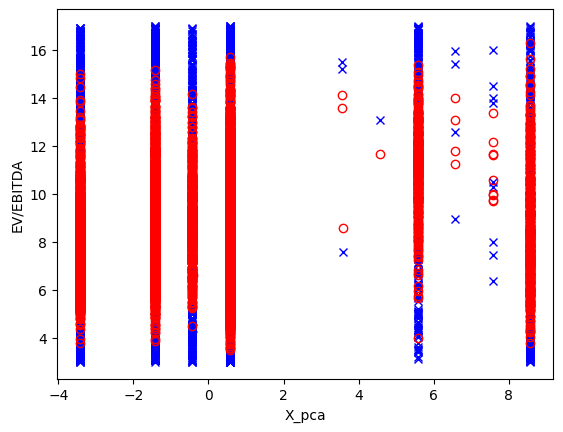

In [126]:
#Visulaization utlisons PCA
X_pca = PCA (n_components = 1).fit_transform (X_train)
X_pca = pd.DataFrame ( X_pca, columns = ['X1'], index = X_train.index )

#Predictions
#y_train_predicted = model_linear_regression.predict (X_train)

#Visualisation
plt.plot ( X_pca, y_train, 'bx' )
plt.plot ( X_pca, y_train_predicted, 'ro', fillstyle = 'none' )
plt.xlabel ( 'X_pca' )
plt.ylabel ("EV/EBITDA")

##### Neural Networks 

In [40]:
#Initialisation du model
model_DNN = keras.models.Sequential ( name = 'DNN_predictif_ev_ebitda' )

num_unit1 = 100
num_unit2 = 100
num_unit3 = 100
num_unit4 = 100
num_unit5 = 100
num_unit6 = 100
num_unit7 = 100
num_unit8 = 100
num_unit9 = 100
num_unit10 = 100

taux_dropout1 = 0.2
taux_dropout2 = 0.2
taux_dropout3 = 0.2
taux_dropout4 = 0.2
taux_dropout5 = 0.2
taux_dropout6 = 0.2

#Input layer ------------------------------------------------------------------------------------------------------
model_DNN.add ( layers.Input ( (X_train.shape [1],), name = 'Input_Layer' ) )

#Hidden layer 1 ------------------------------------------------------------------------------------------------------
model_DNN.add ( layers.Dense ( num_unit1, activation = 'relu',  name = 'Hidden_layer_1' ) )
#model_DNN.add ( layers.Dropout ( taux_dropout1 ) )
#Hidden layer 2------------------------------------------------------------------------------------------------------
model_DNN.add ( layers.Dense ( num_unit2, activation = 'relu',  name = 'Hidden_layer_2' ) )
#model_DNN.add ( layers.Dropout ( taux_dropout2 ) )
#Hidden layer 3------------------------------------------------------------------------------------------------------
model_DNN.add ( layers.Dense ( num_unit3, activation = 'relu',  name = 'Hidden_layer_3' ) )
#model_DNN.add ( layers.Dropout ( taux_dropout3 ) )
#Hidden layer 4------------------------------------------------------------------------------------------------------
model_DNN.add ( layers.Dense ( num_unit4, activation = 'relu',  name = 'Hidden_layer_4' ) )
#model_DNN.add ( layers.Dropout ( taux_dropout4 ) )
#Hidden layer 5------------------------------------------------------------------------------------------------------
model_DNN.add ( layers.Dense ( num_unit5, activation = 'relu',  name = 'Hidden_layer_5' ) )
#model_DNN.add ( layers.Dropout ( taux_dropout5 ) )
#Hidden layer 6------------------------------------------------------------------------------------------------------
model_DNN.add ( layers.Dense ( num_unit6, activation = 'relu',  name = 'Hidden_layer_6' ) )
#model_DNN.add ( layers.Dropout ( taux_dropout6 ) )
#Hidden layer 7------------------------------------------------------------------------------------------------------
model_DNN.add ( layers.Dense ( num_unit7, activation = 'relu',  name = 'Hidden_layer_7' ) )
#model_DNN.add ( layers.Dropout ( taux_dropout6 ) )
#Hidden layer 8------------------------------------------------------------------------------------------------------
model_DNN.add ( layers.Dense ( num_unit8, activation = 'relu',  name = 'Hidden_layer_8' ) )
#model_DNN.add ( layers.Dropout ( taux_dropout6 ) )
#Hidden layer 9------------------------------------------------------------------------------------------------------
model_DNN.add ( layers.Dense ( num_unit9, activation = 'relu',  name = 'Hidden_layer_9' ) )
#model_DNN.add ( layers.Dropout ( taux_dropout6 ) )
#Hidden layer 10------------------------------------------------------------------------------------------------------
model_DNN.add ( layers.Dense ( num_unit10, activation = 'relu', name = 'Hidden_layer_10' ) )
#model_DNN.add ( layers.Dropout ( taux_dropout6 ) )

#Output layer ------------------------------------------------------------------------------------------------------
model_DNN.add ( layers.Dense ( 1, name = 'Output_layer' ) )
#kernel_regularizer = regularizers.L2 (0.01),

In [41]:
#Caractéristiques du model
model_DNN.compile ( optimizer = optimizers.Adam ( 0.0001 ), loss = 'MSE', metrics = ['MAE'] )

In [42]:
#MODEL
model_DNN.summary()

Model: "DNN_predictif_ev_ebitda"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Hidden_layer_1 (Dense)      (None, 100)               800       
                                                                 
 Hidden_layer_2 (Dense)      (None, 100)               10100     
                                                                 
 Hidden_layer_3 (Dense)      (None, 100)               10100     
                                                                 
 Hidden_layer_4 (Dense)      (None, 100)               10100     
                                                                 
 Hidden_layer_5 (Dense)      (None, 100)               10100     
                                                                 
 Hidden_layer_6 (Dense)      (None, 100)               10100     
                                                                 
 Hidden_layer_7 (Dense)      (None, 100)   

In [43]:
#Entrainnement du model
hist = model_DNN.fit ( X_train, y_train, 
                        epochs = 200,
                        batch_size = 34,
                        validation_data = [X_validation, y_validation] )    

Epoch 1/200
155/155 [==============================] - 2s 6ms/step - loss: 24.2397 - MAE: 4.1767 - val_loss: 4.8941 - val_MAE: 1.8407
Epoch 2/200
155/155 [==============================] - 1s 4ms/step - loss: 4.4256 - MAE: 1.7576 - val_loss: 4.0520 - val_MAE: 1.7213
Epoch 3/200
155/155 [==============================] - 1s 4ms/step - loss: 3.9552 - MAE: 1.6934 - val_loss: 3.8405 - val_MAE: 1.6755
Epoch 4/200
155/155 [==============================] - 1s 5ms/step - loss: 3.8825 - MAE: 1.6805 - val_loss: 3.8886 - val_MAE: 1.6900
Epoch 5/200
155/155 [==============================] - 1s 4ms/step - loss: 3.8619 - MAE: 1.6766 - val_loss: 3.8080 - val_MAE: 1.6692
Epoch 6/200
155/155 [==============================] - 1s 4ms/step - loss: 3.8480 - MAE: 1.6735 - val_loss: 3.8226 - val_MAE: 1.6760
Epoch 7/200
155/155 [==============================] - 1s 4ms/step - loss: 3.8624 - MAE: 1.6763 - val_loss: 3.7917 - val_MAE: 1.6649
Epoch 8/200
155/155 [==============================] - 1s 4ms/step -

In [36]:
loss = pd.DataFrame ( { 'loss' : hist.history['loss'], 'validation_loss' :hist.history ['val_loss'] })
px.line ( loss, x = range (len(loss)), y = ['loss', 'validation_loss'], height = 600, width = 1200 )

In [37]:
#Données d'entrainnement
y_train_predicted = model_DNN.predict ( X_train )
y_train_predicted = y_train_predicted.reshape (y_train.shape)
print ( 'MSE du DNN sur train set =', np.mean ( (y_train - y_train_predicted) ** 2 ))
print ( 'MAE du DNN sur train set =', np.mean ( np.abs(y_train - y_train_predicted) ) )
print ( 'r2_score du DNN sur train set =', r2_score ( y_train, y_train_predicted ) )

164/164 [==============================] - 0s 2ms/step
MSE du DNN sur train set = 3.6930110408674013
MAE du DNN sur train set = 1.6291939218676632
r2_score du DNN sur train set = 0.022954304863959996


In [39]:
#Données test
y_test_predicted = model_DNN.predict ( X_test )
y_test_predicted = y_test_predicted.reshape (y_test.shape)
print ( 'MSE du DNN sur test set =', np.mean ( (y_test - y_test_predicted) ** 2 ))
print ( 'MAE du DNN sur test set =', np.mean ( np.abs(y_test - y_test_predicted) ) )
print ( 'r2_score du DNN sur test set =', r2_score ( y_test, y_test_predicted ) )

6/6 [==============================] - 0s 2ms/step
MSE du DNN sur test set = 3.9322387166170447
MAE du DNN sur test set = 1.6528622483407986
r2_score du DNN sur test set = -0.011078645062811754


In [29]:
y_test_df = pd.DataFrame ( {'y_test' : y_test, 'y_test_predicted' : y_test_predicted} )
y_test_df = y_test_df.reset_index(drop = True)
px.line ( y_test_df,x = y_test_df.index, y = ['y_test', 'y_test_predicted'] )
#y_train_df

Text(0.5, 1.0, "Visualisation des données à l'aide du PCA")

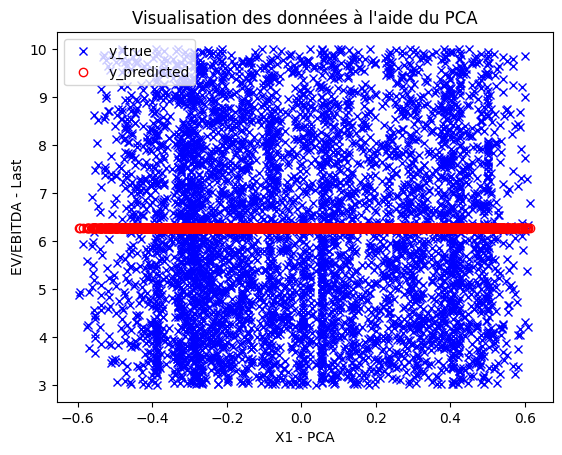

In [30]:
#Visulaization utlisons PCA
X_pca = PCA (n_components = 1).fit_transform (X_train)
X_pca = pd.DataFrame ( X_pca, columns = ['X1'], index = X_train.index )


#Predictions
#y_predicted = model_DNN.predict (X)

#Visualisation
plt.plot ( X_pca['X1'], y_train,  'bx' )
plt.plot ( X_pca['X1'], y_train_predicted, 'ro', fillstyle = 'none' )

plt.legend ( ['y_true', 'y_predicted'] )
plt.xlabel ('X1 - PCA')
plt.ylabel ( 'EV/EBITDA - Last' )
plt.title ( '''Visualisation des données à l'aide du PCA''' )
#plt.plot ( X_pca, y_train_predicted, 'r' )

In [55]:
#Comparaison avec un model qui ne predit que la moyen
mean = np.ones ( y_test.shape )
mean = mean * y_test.mean()
mean

array([12.66026846, 12.66026846, 12.66026846, 12.66026846, 12.66026846,
       12.66026846, 12.66026846, 12.66026846, 12.66026846, 12.66026846,
       12.66026846, 12.66026846, 12.66026846, 12.66026846, 12.66026846,
       12.66026846, 12.66026846, 12.66026846, 12.66026846, 12.66026846,
       12.66026846, 12.66026846, 12.66026846, 12.66026846, 12.66026846,
       12.66026846, 12.66026846, 12.66026846, 12.66026846, 12.66026846,
       12.66026846, 12.66026846, 12.66026846, 12.66026846, 12.66026846,
       12.66026846, 12.66026846, 12.66026846, 12.66026846, 12.66026846,
       12.66026846, 12.66026846, 12.66026846, 12.66026846, 12.66026846,
       12.66026846, 12.66026846, 12.66026846, 12.66026846, 12.66026846,
       12.66026846, 12.66026846, 12.66026846, 12.66026846, 12.66026846,
       12.66026846, 12.66026846, 12.66026846, 12.66026846, 12.66026846,
       12.66026846, 12.66026846, 12.66026846, 12.66026846, 12.66026846,
       12.66026846, 12.66026846, 12.66026846, 12.66026846, 12.66

In [56]:
print ( 'MSE du model moyen sur train set =', np.mean ( (y_test - mean) ** 2 ))
print ( 'MAE du model moyen sur train set =', np.mean ( np.abs(y_test - mean) ) )
print ( 'r2_score sur train set =', r2_score ( y_test, mean ) )

MSE du model moyen sur train set = 81.11529791450836
MAE du model moyen sur train set = 6.526919508130264
r2_score sur train set = 0.0


In [59]:
erreur = np.abs(y_test - y_test_predicted).sort_values( ascending = False)
erreur

72678    36.176334
56546    29.689620
16471    27.401511
40116    26.013051
20207    25.623795
           ...    
71342     0.120559
68747     0.100105
27087     0.081682
26716     0.076597
73323     0.068692
Name: EV/EBITDA - Last, Length: 149, dtype: float64

In [220]:
print ( 'y_test :\n', y_test.sort_values () )
print ( 'y_test_predicted :\n', np.sort (y_test_predicted))


y_test :
 106       3.06
16094     3.14
75243     3.29
14641     3.39
4381      3.45
         ...  
32091    45.18
35611    47.11
802      47.84
35683    48.63
16276    49.59
Name: EV/EBITDA - Last, Length: 149, dtype: float64
y_test_predicted :
 [ 7.3755565  7.378904   7.3790913  7.3849273  7.3859153  7.3962345
  7.416      7.440906   7.4729114  7.507282   7.508206   7.5659275
  7.6416245  7.677482   7.7111464  7.809169   7.895043   7.8983593
  7.901111   7.927023   7.959628   7.976384   8.02041    8.082647
  8.10243    8.182367   8.261572   8.317199   8.497843   8.511635
  8.539945   8.541579   8.560848   8.695763   8.714247   8.746037
  8.748851   8.811089   8.834467   8.858101   8.894645   8.939053
  9.023871   9.045743   9.069536   9.076068   9.106612   9.188367
  9.24775    9.262993   9.305733   9.385595   9.531865   9.577801
  9.657215   9.6795845  9.725607   9.83228    9.846534   9.944734
  9.981117  10.098163  10.130287  10.159616  10.186226  10.191482
 10.258535  10.387759  1